In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [4]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
# from custom_classes_defs.unet0 import * 
# from custom_classes_defs.Unet_like import *  
# from custom_classes_defs.unet import *  
from custom_classes_defs.fnet0 import *
# from custom_classes_defs.fnet_like import *
# from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 512
EPOCHS = 100
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-06-02 20:04:40.638186: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-02 20:04:41.889700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 20:04:41.890748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 20:04:42.115755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-02 20:04:42.481108: I tensorflow/core/platform/cpu_feature_guar

In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi
    
if NUM_GPU>1:
    strategy = tf.distribute.MirroredStrategy()
    # strategy = tf.distribute.MultiWorkerMirroredStrategy()
    BATCH_SIZE = strategy.num_replicas_in_sync * BATCH_SIZE

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1


/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Sun Jun  2 20:05:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:3B:00.0 Off |                    0 |
| N/A   34C    P0              34W / 250W |   1637MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Data preparation and model configurations

In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Images and annations for Thebe seismic data
start = time.time()
img_url = '../thebe_new/seismic'
target_url = '../thebe_new/fault'
seis = Thebe(img_url, target_url)
    
# Create datasets for respective data samples and labels
x_test, y_test = seis.data_generator('test', as_numpy=True)
        
print("Size of test data: {}".format(seis.test_size)) 

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


Size of test data: 224122
...elapsed time: ___ 0.27 minutes___


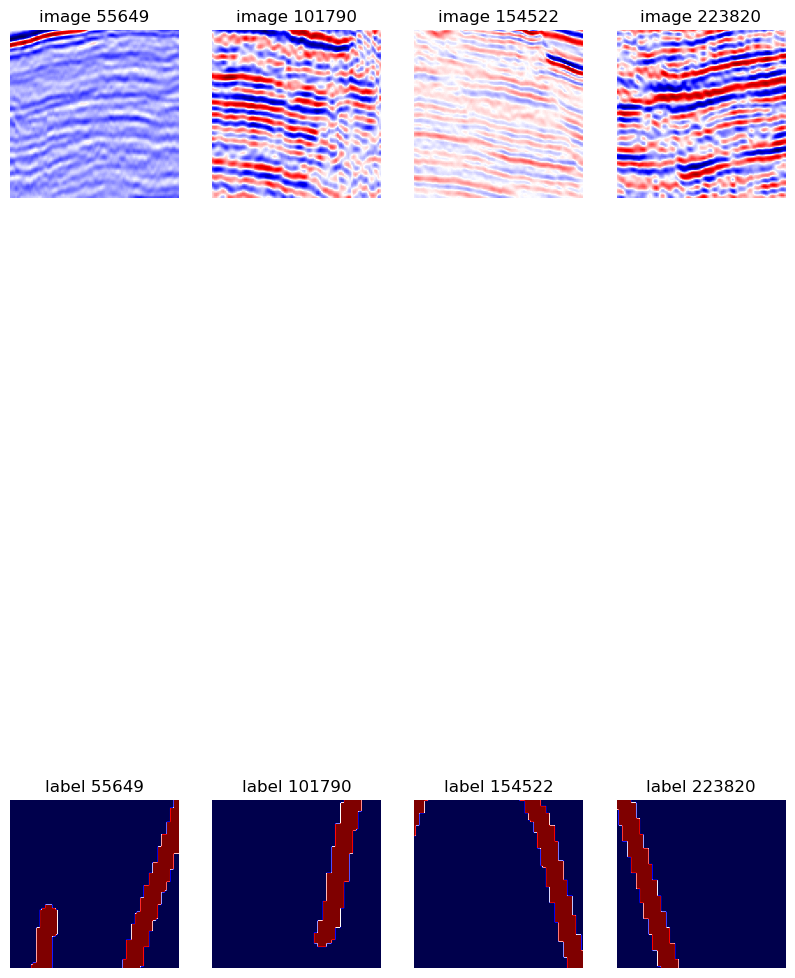

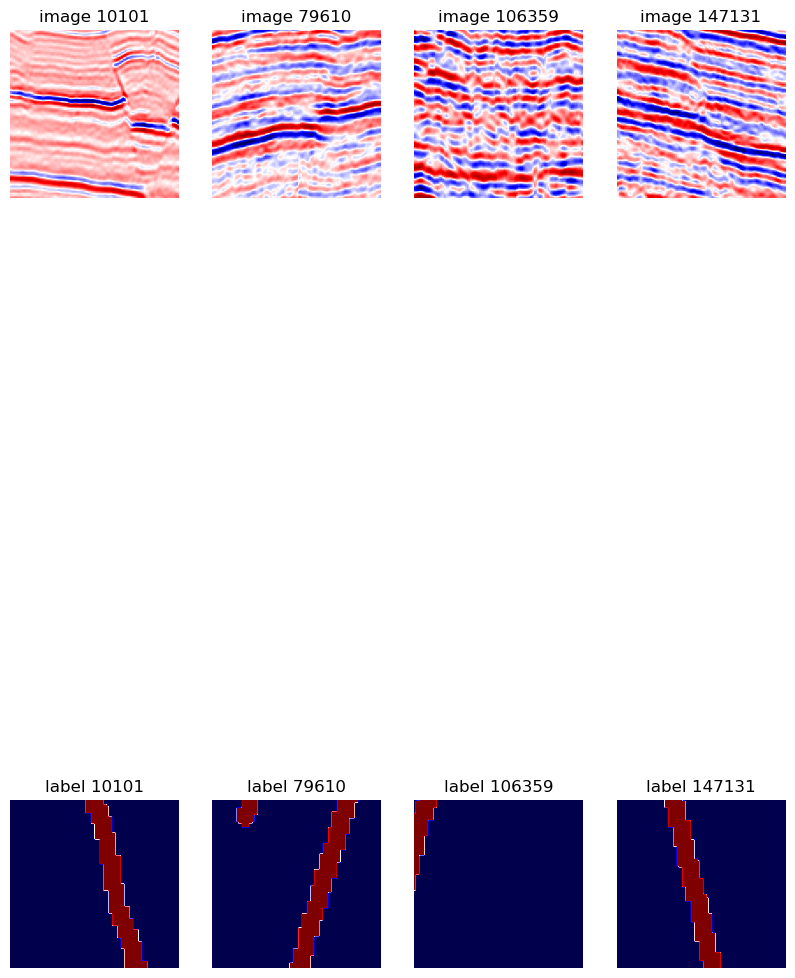

In [7]:
if INTERACTIVE_SESSION:
    seis.display_sample_images(x_test, y_test, num_images=4)
    seis.display_sample_images(x_test, y_test, num_images=4)


In [8]:
# Model configurations
conf = model_config(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path='./Thebe/fnet00',
    img_shape=seis.img_size,
    target_size=seis.img_size,
    threshold=seis.threshold,
    pos_label=seis.pos_label,
    train_size=seis.train_size,
    test_size=seis.test_size,
    multiple_gpu_device=(NUM_GPU>1),
    validation_size=seis.validation_size
)

assert not(conf.new_training_session)

conf.info()

             NUM_GPU: 1
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: False
           pos_label: 1
resume_training_session: 0
           save_path: ./Thebe/fnet00
           test_size: 224122
           threshold: 0.5
          train_size: None
       training_args:
                        epochs: 100
                    batch_size: 512
                       shuffle: True
                       verbose: 0
   training_duration: None
     validation_size: None


2024-06-02 20:06:02.038720: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38374 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capability: 8.0


### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    print(f"Number of devices: {strategy.num_replicas_in_sync}")

# m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch, add_residual=False)
model = m_obj.build_model()
# model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 8,058,529
Total trainable wieghts: 8,049,185
Total non-trainable wieghts: 9,344


### Train  model



	Train fnet model
-------------------------------------------------------


model train history 'model+_history.pickle'loaded!
             NUM_GPU: 1
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./Thebe/fnet00
           test_size: 66077
           threshold: 0.5
          train_size: 181029
       training_args:
                        epochs: 100
                    batch_size: 64
                       shuffle: True
                       verbose: 0
               validation_data: <class 'tensorflow.pytho

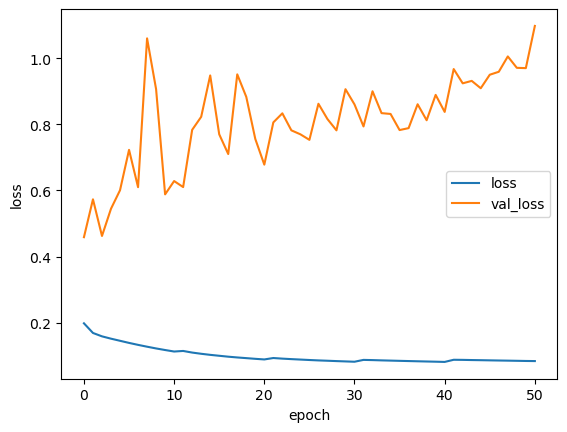

In [10]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=None, 
        plot_history=INTERACTIVE_SESSION
)


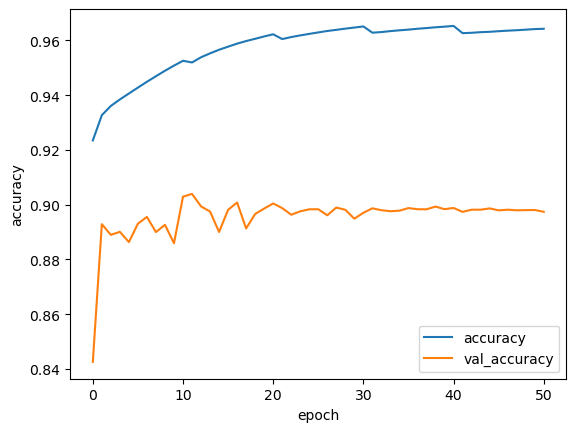

In [11]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['accuracy','val_accuracy'])

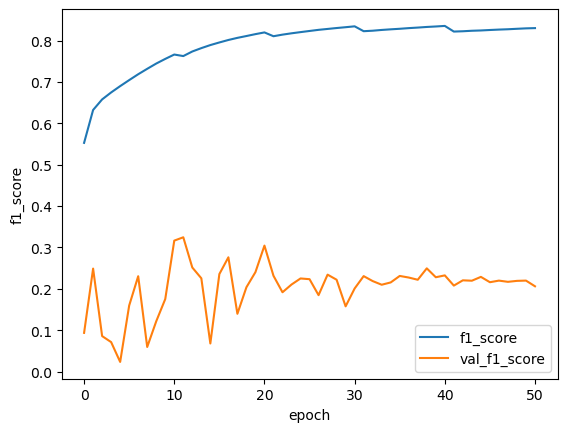

In [12]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['f1_score','val_f1_score'])

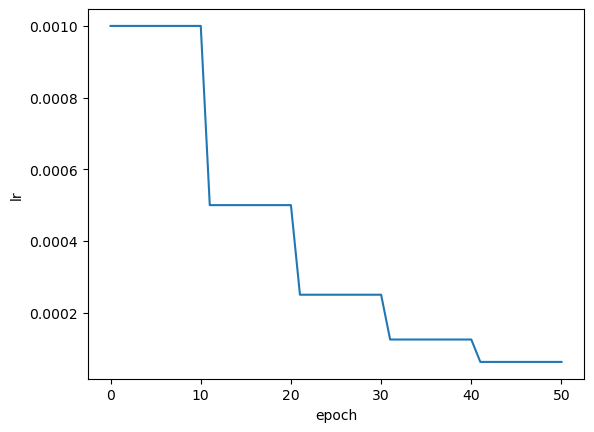

In [13]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, 'lr')

### Evaluate and Vizualize

In [14]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
start = time.time()
y_pred = model.predict(x_test)

start = time.time() - start
print("evaluation elapsed time:___{:5.2f}___minutes" \
                .format(start/60))




	Evaluate fnet model
-------------------------------------------------------


2024-06-02 20:07:36.503346: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


   1/7004 [..............................] - ETA: 24:21:55

   4/7004 [..............................] - ETA: 2:28    

   7/7004 [..............................] - ETA: 2:35

  10/7004 [..............................] - ETA: 2:40

  13/7004 [..............................] - ETA: 2:32

  16/7004 [..............................] - ETA: 2:26

  20/7004 [..............................] - ETA: 2:17

  24/7004 [..............................] - ETA: 2:12

  28/7004 [..............................] - ETA: 2:08

  32/7004 [..............................] - ETA: 2:06

  36/7004 [..............................] - ETA: 2:04

  40/7004 [..............................] - ETA: 2:02

  43/7004 [..............................] - ETA: 2:02

  47/7004 [..............................] - ETA: 2:00

  51/7004 [..............................] - ETA: 1:59

  55/7004 [..............................] - ETA: 1:59

  59/7004 [..............................] - ETA: 1:57

  63/7004 [..............................] - ETA: 1:57

  67/7004 [..............................] - ETA: 1:56

  71/7004 [..............................] - ETA: 1:56

  75/7004 [..............................] - ETA: 1:55

  79/7004 [..............................] - ETA: 1:55

  83/7004 [..............................] - ETA: 1:54

  87/7004 [..............................] - ETA: 1:54

  91/7004 [..............................] - ETA: 1:53

  95/7004 [..............................] - ETA: 1:53

  99/7004 [..............................] - ETA: 1:53

 103/7004 [..............................] - ETA: 1:52

 107/7004 [..............................] - ETA: 1:52

 111/7004 [..............................] - ETA: 1:52

 115/7004 [..............................] - ETA: 1:52

 119/7004 [..............................] - ETA: 1:52

 123/7004 [..............................] - ETA: 1:51

 127/7004 [..............................] - ETA: 1:51

 131/7004 [..............................] - ETA: 1:51

 134/7004 [..............................] - ETA: 1:51

 138/7004 [..............................] - ETA: 1:51

 142/7004 [..............................] - ETA: 1:50

 145/7004 [..............................] - ETA: 1:50

 149/7004 [..............................] - ETA: 1:50

 153/7004 [..............................] - ETA: 1:50

 157/7004 [..............................] - ETA: 1:50

 161/7004 [..............................] - ETA: 1:50

 165/7004 [..............................] - ETA: 1:49

 169/7004 [..............................] - ETA: 1:49

 173/7004 [..............................] - ETA: 1:49

 177/7004 [..............................] - ETA: 1:49

 181/7004 [..............................] - ETA: 1:49

 184/7004 [..............................] - ETA: 1:49

 188/7004 [..............................] - ETA: 1:49

 192/7004 [..............................] - ETA: 1:49

 196/7004 [..............................] - ETA: 1:49

 200/7004 [..............................] - ETA: 1:48

 204/7004 [..............................] - ETA: 1:48

 208/7004 [..............................] - ETA: 1:48

 212/7004 [..............................] - ETA: 1:48

 216/7004 [..............................] - ETA: 1:48

 220/7004 [..............................] - ETA: 1:48

 224/7004 [..............................] - ETA: 1:48

 228/7004 [..............................] - ETA: 1:48

 232/7004 [..............................] - ETA: 1:48

 236/7004 [>.............................] - ETA: 1:47

 240/7004 [>.............................] - ETA: 1:47

 244/7004 [>.............................] - ETA: 1:47

 248/7004 [>.............................] - ETA: 1:47

 252/7004 [>.............................] - ETA: 1:47

 256/7004 [>.............................] - ETA: 1:47

 260/7004 [>.............................] - ETA: 1:47

 264/7004 [>.............................] - ETA: 1:47

 268/7004 [>.............................] - ETA: 1:47

 272/7004 [>.............................] - ETA: 1:47

 276/7004 [>.............................] - ETA: 1:47

 280/7004 [>.............................] - ETA: 1:46

 284/7004 [>.............................] - ETA: 1:46

 288/7004 [>.............................] - ETA: 1:46

 292/7004 [>.............................] - ETA: 1:46

 296/7004 [>.............................] - ETA: 1:46

 300/7004 [>.............................] - ETA: 1:46

 304/7004 [>.............................] - ETA: 1:46

 307/7004 [>.............................] - ETA: 1:46

 311/7004 [>.............................] - ETA: 1:46

 315/7004 [>.............................] - ETA: 1:46

 319/7004 [>.............................] - ETA: 1:46

 323/7004 [>.............................] - ETA: 1:46

 327/7004 [>.............................] - ETA: 1:45

 331/7004 [>.............................] - ETA: 1:45

 335/7004 [>.............................] - ETA: 1:45

 339/7004 [>.............................] - ETA: 1:45

 343/7004 [>.............................] - ETA: 1:45

 347/7004 [>.............................] - ETA: 1:45

 351/7004 [>.............................] - ETA: 1:45

 355/7004 [>.............................] - ETA: 1:45

 359/7004 [>.............................] - ETA: 1:45

 363/7004 [>.............................] - ETA: 1:45

 367/7004 [>.............................] - ETA: 1:45

 371/7004 [>.............................] - ETA: 1:45

 375/7004 [>.............................] - ETA: 1:44

 379/7004 [>.............................] - ETA: 1:44

 383/7004 [>.............................] - ETA: 1:44

 387/7004 [>.............................] - ETA: 1:44

 391/7004 [>.............................] - ETA: 1:44

 394/7004 [>.............................] - ETA: 1:44

 398/7004 [>.............................] - ETA: 1:44

 402/7004 [>.............................] - ETA: 1:44

 406/7004 [>.............................] - ETA: 1:44

 410/7004 [>.............................] - ETA: 1:44

 414/7004 [>.............................] - ETA: 1:44

 418/7004 [>.............................] - ETA: 1:44

 422/7004 [>.............................] - ETA: 1:44

 426/7004 [>.............................] - ETA: 1:43

 430/7004 [>.............................] - ETA: 1:43

 434/7004 [>.............................] - ETA: 1:43

 438/7004 [>.............................] - ETA: 1:43

 442/7004 [>.............................] - ETA: 1:43

 446/7004 [>.............................] - ETA: 1:43

 450/7004 [>.............................] - ETA: 1:43

 454/7004 [>.............................] - ETA: 1:43

 458/7004 [>.............................] - ETA: 1:43

 461/7004 [>.............................] - ETA: 1:43

 465/7004 [>.............................] - ETA: 1:43

 469/7004 [=>............................] - ETA: 1:43

 473/7004 [=>............................] - ETA: 1:43

 477/7004 [=>............................] - ETA: 1:43

 481/7004 [=>............................] - ETA: 1:43

 484/7004 [=>............................] - ETA: 1:43

 488/7004 [=>............................] - ETA: 1:42

 492/7004 [=>............................] - ETA: 1:42

 496/7004 [=>............................] - ETA: 1:42

 500/7004 [=>............................] - ETA: 1:42

 504/7004 [=>............................] - ETA: 1:42

 508/7004 [=>............................] - ETA: 1:42

 512/7004 [=>............................] - ETA: 1:42

 516/7004 [=>............................] - ETA: 1:42

 520/7004 [=>............................] - ETA: 1:42

 524/7004 [=>............................] - ETA: 1:42

 528/7004 [=>............................] - ETA: 1:42

 532/7004 [=>............................] - ETA: 1:42

 536/7004 [=>............................] - ETA: 1:42

 540/7004 [=>............................] - ETA: 1:41

 544/7004 [=>............................] - ETA: 1:41

 548/7004 [=>............................] - ETA: 1:41

 552/7004 [=>............................] - ETA: 1:41

 556/7004 [=>............................] - ETA: 1:41

 560/7004 [=>............................] - ETA: 1:41

 564/7004 [=>............................] - ETA: 1:41

 568/7004 [=>............................] - ETA: 1:41

 572/7004 [=>............................] - ETA: 1:41

 576/7004 [=>............................] - ETA: 1:41

 580/7004 [=>............................] - ETA: 1:41

 583/7004 [=>............................] - ETA: 1:41

 587/7004 [=>............................] - ETA: 1:41

 591/7004 [=>............................] - ETA: 1:41

 595/7004 [=>............................] - ETA: 1:41

 598/7004 [=>............................] - ETA: 1:41

 602/7004 [=>............................] - ETA: 1:40

 606/7004 [=>............................] - ETA: 1:40

 609/7004 [=>............................] - ETA: 1:40

 613/7004 [=>............................] - ETA: 1:40

 617/7004 [=>............................] - ETA: 1:40

 621/7004 [=>............................] - ETA: 1:40

 625/7004 [=>............................] - ETA: 1:40

 629/7004 [=>............................] - ETA: 1:40

 633/7004 [=>............................] - ETA: 1:40

 637/7004 [=>............................] - ETA: 1:40

 641/7004 [=>............................] - ETA: 1:40

 645/7004 [=>............................] - ETA: 1:40

 649/7004 [=>............................] - ETA: 1:40

 653/7004 [=>............................] - ETA: 1:40

 657/7004 [=>............................] - ETA: 1:39

 661/7004 [=>............................] - ETA: 1:39

 665/7004 [=>............................] - ETA: 1:39

 669/7004 [=>............................] - ETA: 1:39

 673/7004 [=>............................] - ETA: 1:39

 677/7004 [=>............................] - ETA: 1:39

 681/7004 [=>............................] - ETA: 1:39

 685/7004 [=>............................] - ETA: 1:39

 689/7004 [=>............................] - ETA: 1:39

 693/7004 [=>............................] - ETA: 1:39

 697/7004 [=>............................] - ETA: 1:39

 701/7004 [==>...........................] - ETA: 1:39

 705/7004 [==>...........................] - ETA: 1:39

 709/7004 [==>...........................] - ETA: 1:39

 713/7004 [==>...........................] - ETA: 1:39

 717/7004 [==>...........................] - ETA: 1:38

 721/7004 [==>...........................] - ETA: 1:38

 725/7004 [==>...........................] - ETA: 1:38

 729/7004 [==>...........................] - ETA: 1:38

 733/7004 [==>...........................] - ETA: 1:38

 737/7004 [==>...........................] - ETA: 1:38

 741/7004 [==>...........................] - ETA: 1:38

 745/7004 [==>...........................] - ETA: 1:38

 749/7004 [==>...........................] - ETA: 1:38

 753/7004 [==>...........................] - ETA: 1:38

 757/7004 [==>...........................] - ETA: 1:38

 761/7004 [==>...........................] - ETA: 1:38

 764/7004 [==>...........................] - ETA: 1:38

 768/7004 [==>...........................] - ETA: 1:38

 772/7004 [==>...........................] - ETA: 1:38

 776/7004 [==>...........................] - ETA: 1:38

 780/7004 [==>...........................] - ETA: 1:37

 784/7004 [==>...........................] - ETA: 1:37

 788/7004 [==>...........................] - ETA: 1:37

 792/7004 [==>...........................] - ETA: 1:37

 796/7004 [==>...........................] - ETA: 1:37

 800/7004 [==>...........................] - ETA: 1:37

 804/7004 [==>...........................] - ETA: 1:37

 808/7004 [==>...........................] - ETA: 1:37

 812/7004 [==>...........................] - ETA: 1:37

 816/7004 [==>...........................] - ETA: 1:37

 820/7004 [==>...........................] - ETA: 1:37

 824/7004 [==>...........................] - ETA: 1:37

 828/7004 [==>...........................] - ETA: 1:37

 832/7004 [==>...........................] - ETA: 1:37

 836/7004 [==>...........................] - ETA: 1:37

 840/7004 [==>...........................] - ETA: 1:36

 844/7004 [==>...........................] - ETA: 1:36

 848/7004 [==>...........................] - ETA: 1:36

 852/7004 [==>...........................] - ETA: 1:36

 856/7004 [==>...........................] - ETA: 1:36

 860/7004 [==>...........................] - ETA: 1:36

 864/7004 [==>...........................] - ETA: 1:36

 868/7004 [==>...........................] - ETA: 1:36

 872/7004 [==>...........................] - ETA: 1:36

 876/7004 [==>...........................] - ETA: 1:36

 880/7004 [==>...........................] - ETA: 1:36

 884/7004 [==>...........................] - ETA: 1:36

 888/7004 [==>...........................] - ETA: 1:36

 892/7004 [==>...........................] - ETA: 1:36

 896/7004 [==>...........................] - ETA: 1:36

 900/7004 [==>...........................] - ETA: 1:35

 904/7004 [==>...........................] - ETA: 1:35

 908/7004 [==>...........................] - ETA: 1:35

 912/7004 [==>...........................] - ETA: 1:35

 916/7004 [==>...........................] - ETA: 1:35

 920/7004 [==>...........................] - ETA: 1:35

 924/7004 [==>...........................] - ETA: 1:35

 928/7004 [==>...........................] - ETA: 1:35

 932/7004 [==>...........................] - ETA: 1:35

 936/7004 [===>..........................] - ETA: 1:35

 940/7004 [===>..........................] - ETA: 1:35

 944/7004 [===>..........................] - ETA: 1:35

 948/7004 [===>..........................] - ETA: 1:35

 952/7004 [===>..........................] - ETA: 1:35

 956/7004 [===>..........................] - ETA: 1:35

 960/7004 [===>..........................] - ETA: 1:34

 964/7004 [===>..........................] - ETA: 1:34

 968/7004 [===>..........................] - ETA: 1:34

 972/7004 [===>..........................] - ETA: 1:34

 976/7004 [===>..........................] - ETA: 1:34

 980/7004 [===>..........................] - ETA: 1:34

 984/7004 [===>..........................] - ETA: 1:34

 988/7004 [===>..........................] - ETA: 1:34

 992/7004 [===>..........................] - ETA: 1:34

 996/7004 [===>..........................] - ETA: 1:34

1000/7004 [===>..........................] - ETA: 1:34

1004/7004 [===>..........................] - ETA: 1:34

1008/7004 [===>..........................] - ETA: 1:34

1012/7004 [===>..........................] - ETA: 1:34

1016/7004 [===>..........................] - ETA: 1:34

1020/7004 [===>..........................] - ETA: 1:34

1024/7004 [===>..........................] - ETA: 1:33

1028/7004 [===>..........................] - ETA: 1:33

1032/7004 [===>..........................] - ETA: 1:33

1036/7004 [===>..........................] - ETA: 1:33

1040/7004 [===>..........................] - ETA: 1:33

1044/7004 [===>..........................] - ETA: 1:33

1048/7004 [===>..........................] - ETA: 1:33

1052/7004 [===>..........................] - ETA: 1:33

1056/7004 [===>..........................] - ETA: 1:33

1060/7004 [===>..........................] - ETA: 1:33

1064/7004 [===>..........................] - ETA: 1:33

1068/7004 [===>..........................] - ETA: 1:33

1072/7004 [===>..........................] - ETA: 1:33

1076/7004 [===>..........................] - ETA: 1:33

1080/7004 [===>..........................] - ETA: 1:33

1084/7004 [===>..........................] - ETA: 1:32

1088/7004 [===>..........................] - ETA: 1:32

1092/7004 [===>..........................] - ETA: 1:32

1096/7004 [===>..........................] - ETA: 1:32

1100/7004 [===>..........................] - ETA: 1:32

1104/7004 [===>..........................] - ETA: 1:32

1108/7004 [===>..........................] - ETA: 1:32

1112/7004 [===>..........................] - ETA: 1:32

1116/7004 [===>..........................] - ETA: 1:32

1120/7004 [===>..........................] - ETA: 1:32

1124/7004 [===>..........................] - ETA: 1:32

1128/7004 [===>..........................] - ETA: 1:32

1132/7004 [===>..........................] - ETA: 1:32

1136/7004 [===>..........................] - ETA: 1:32

1140/7004 [===>..........................] - ETA: 1:32

1144/7004 [===>..........................] - ETA: 1:32

1148/7004 [===>..........................] - ETA: 1:31

1152/7004 [===>..........................] - ETA: 1:31

1156/7004 [===>..........................] - ETA: 1:31

1160/7004 [===>..........................] - ETA: 1:31

1164/7004 [===>..........................] - ETA: 1:31

1168/7004 [====>.........................] - ETA: 1:31

1172/7004 [====>.........................] - ETA: 1:31

1176/7004 [====>.........................] - ETA: 1:31

1180/7004 [====>.........................] - ETA: 1:31

1184/7004 [====>.........................] - ETA: 1:31

1188/7004 [====>.........................] - ETA: 1:31

1192/7004 [====>.........................] - ETA: 1:31

1196/7004 [====>.........................] - ETA: 1:31

1200/7004 [====>.........................] - ETA: 1:31

1204/7004 [====>.........................] - ETA: 1:31

1208/7004 [====>.........................] - ETA: 1:31

1212/7004 [====>.........................] - ETA: 1:30

1216/7004 [====>.........................] - ETA: 1:30

1220/7004 [====>.........................] - ETA: 1:30

1224/7004 [====>.........................] - ETA: 1:30

1228/7004 [====>.........................] - ETA: 1:30

1232/7004 [====>.........................] - ETA: 1:30

1236/7004 [====>.........................] - ETA: 1:30

1240/7004 [====>.........................] - ETA: 1:30

1244/7004 [====>.........................] - ETA: 1:30

1248/7004 [====>.........................] - ETA: 1:30

1251/7004 [====>.........................] - ETA: 1:30

1255/7004 [====>.........................] - ETA: 1:30

1259/7004 [====>.........................] - ETA: 1:30

1263/7004 [====>.........................] - ETA: 1:30

1267/7004 [====>.........................] - ETA: 1:30

1271/7004 [====>.........................] - ETA: 1:30

1275/7004 [====>.........................] - ETA: 1:29

1279/7004 [====>.........................] - ETA: 1:29

1283/7004 [====>.........................] - ETA: 1:29

1287/7004 [====>.........................] - ETA: 1:29

1291/7004 [====>.........................] - ETA: 1:29

1295/7004 [====>.........................] - ETA: 1:29

1299/7004 [====>.........................] - ETA: 1:29

1303/7004 [====>.........................] - ETA: 1:29

1306/7004 [====>.........................] - ETA: 1:29

1310/7004 [====>.........................] - ETA: 1:29

1314/7004 [====>.........................] - ETA: 1:29

1318/7004 [====>.........................] - ETA: 1:29

1322/7004 [====>.........................] - ETA: 1:29

1326/7004 [====>.........................] - ETA: 1:29

1330/7004 [====>.........................] - ETA: 1:29

1334/7004 [====>.........................] - ETA: 1:29

1338/7004 [====>.........................] - ETA: 1:28

1342/7004 [====>.........................] - ETA: 1:28

1346/7004 [====>.........................] - ETA: 1:28

1350/7004 [====>.........................] - ETA: 1:28

1354/7004 [====>.........................] - ETA: 1:28

1358/7004 [====>.........................] - ETA: 1:28

1362/7004 [====>.........................] - ETA: 1:28

1365/7004 [====>.........................] - ETA: 1:28

1369/7004 [====>.........................] - ETA: 1:28

1373/7004 [====>.........................] - ETA: 1:28

1377/7004 [====>.........................] - ETA: 1:28

1381/7004 [====>.........................] - ETA: 1:28

1385/7004 [====>.........................] - ETA: 1:28

1389/7004 [====>.........................] - ETA: 1:28

1393/7004 [====>.........................] - ETA: 1:28

1397/7004 [====>.........................] - ETA: 1:28

1401/7004 [=====>........................] - ETA: 1:27

1405/7004 [=====>........................] - ETA: 1:27

1409/7004 [=====>........................] - ETA: 1:27

1413/7004 [=====>........................] - ETA: 1:27

1417/7004 [=====>........................] - ETA: 1:27

1421/7004 [=====>........................] - ETA: 1:27

1425/7004 [=====>........................] - ETA: 1:27

1429/7004 [=====>........................] - ETA: 1:27

1433/7004 [=====>........................] - ETA: 1:27

1437/7004 [=====>........................] - ETA: 1:27

1441/7004 [=====>........................] - ETA: 1:27

1445/7004 [=====>........................] - ETA: 1:27

1449/7004 [=====>........................] - ETA: 1:27

1452/7004 [=====>........................] - ETA: 1:27

1456/7004 [=====>........................] - ETA: 1:27

1460/7004 [=====>........................] - ETA: 1:27

1464/7004 [=====>........................] - ETA: 1:26

1468/7004 [=====>........................] - ETA: 1:26

1472/7004 [=====>........................] - ETA: 1:26

1476/7004 [=====>........................] - ETA: 1:26

1480/7004 [=====>........................] - ETA: 1:26

1484/7004 [=====>........................] - ETA: 1:26

1488/7004 [=====>........................] - ETA: 1:26

1492/7004 [=====>........................] - ETA: 1:26

1496/7004 [=====>........................] - ETA: 1:26

1500/7004 [=====>........................] - ETA: 1:26

1504/7004 [=====>........................] - ETA: 1:26

1508/7004 [=====>........................] - ETA: 1:26

1512/7004 [=====>........................] - ETA: 1:26

1516/7004 [=====>........................] - ETA: 1:26

1520/7004 [=====>........................] - ETA: 1:26

1524/7004 [=====>........................] - ETA: 1:26

1528/7004 [=====>........................] - ETA: 1:25

1532/7004 [=====>........................] - ETA: 1:25

1536/7004 [=====>........................] - ETA: 1:25

1540/7004 [=====>........................] - ETA: 1:25

1544/7004 [=====>........................] - ETA: 1:25

1548/7004 [=====>........................] - ETA: 1:25

1552/7004 [=====>........................] - ETA: 1:25

1556/7004 [=====>........................] - ETA: 1:25

1560/7004 [=====>........................] - ETA: 1:25

1564/7004 [=====>........................] - ETA: 1:25

1568/7004 [=====>........................] - ETA: 1:25

1572/7004 [=====>........................] - ETA: 1:25

1576/7004 [=====>........................] - ETA: 1:25

1580/7004 [=====>........................] - ETA: 1:25

1584/7004 [=====>........................] - ETA: 1:25

1588/7004 [=====>........................] - ETA: 1:25

1592/7004 [=====>........................] - ETA: 1:24

1596/7004 [=====>........................] - ETA: 1:24

1600/7004 [=====>........................] - ETA: 1:24

1604/7004 [=====>........................] - ETA: 1:24

1608/7004 [=====>........................] - ETA: 1:24

1612/7004 [=====>........................] - ETA: 1:24

1616/7004 [=====>........................] - ETA: 1:24

1620/7004 [=====>........................] - ETA: 1:24

1624/7004 [=====>........................] - ETA: 1:24

1628/7004 [=====>........................] - ETA: 1:24

1632/7004 [=====>........................] - ETA: 1:24

1636/7004 [======>.......................] - ETA: 1:24

1640/7004 [======>.......................] - ETA: 1:24

1644/7004 [======>.......................] - ETA: 1:24

1648/7004 [======>.......................] - ETA: 1:24

1652/7004 [======>.......................] - ETA: 1:24

1656/7004 [======>.......................] - ETA: 1:23

1660/7004 [======>.......................] - ETA: 1:23

1664/7004 [======>.......................] - ETA: 1:23

1668/7004 [======>.......................] - ETA: 1:23

1672/7004 [======>.......................] - ETA: 1:23

1676/7004 [======>.......................] - ETA: 1:23

1680/7004 [======>.......................] - ETA: 1:23

1684/7004 [======>.......................] - ETA: 1:23

1688/7004 [======>.......................] - ETA: 1:23

1692/7004 [======>.......................] - ETA: 1:23

1696/7004 [======>.......................] - ETA: 1:23

1700/7004 [======>.......................] - ETA: 1:23

1704/7004 [======>.......................] - ETA: 1:23

1708/7004 [======>.......................] - ETA: 1:23

1712/7004 [======>.......................] - ETA: 1:23

1716/7004 [======>.......................] - ETA: 1:23

1720/7004 [======>.......................] - ETA: 1:22

1724/7004 [======>.......................] - ETA: 1:22

1728/7004 [======>.......................] - ETA: 1:22

1732/7004 [======>.......................] - ETA: 1:22

1735/7004 [======>.......................] - ETA: 1:22

1739/7004 [======>.......................] - ETA: 1:22

1743/7004 [======>.......................] - ETA: 1:22

1747/7004 [======>.......................] - ETA: 1:22

1751/7004 [======>.......................] - ETA: 1:22

1755/7004 [======>.......................] - ETA: 1:22

1759/7004 [======>.......................] - ETA: 1:22

1763/7004 [======>.......................] - ETA: 1:22

1767/7004 [======>.......................] - ETA: 1:22

1771/7004 [======>.......................] - ETA: 1:22

1775/7004 [======>.......................] - ETA: 1:22

1779/7004 [======>.......................] - ETA: 1:22

1783/7004 [======>.......................] - ETA: 1:21

1787/7004 [======>.......................] - ETA: 1:21

1791/7004 [======>.......................] - ETA: 1:21

1794/7004 [======>.......................] - ETA: 1:21

1798/7004 [======>.......................] - ETA: 1:21

1802/7004 [======>.......................] - ETA: 1:21

1806/7004 [======>.......................] - ETA: 1:21

1810/7004 [======>.......................] - ETA: 1:21

1814/7004 [======>.......................] - ETA: 1:21

1818/7004 [======>.......................] - ETA: 1:21

1822/7004 [======>.......................] - ETA: 1:21

1826/7004 [======>.......................] - ETA: 1:21

1830/7004 [======>.......................] - ETA: 1:21

1834/7004 [======>.......................] - ETA: 1:21

1838/7004 [======>.......................] - ETA: 1:21

1842/7004 [======>.......................] - ETA: 1:21

1846/7004 [======>.......................] - ETA: 1:20

1850/7004 [======>.......................] - ETA: 1:20

1854/7004 [======>.......................] - ETA: 1:20

1858/7004 [======>.......................] - ETA: 1:20

1862/7004 [======>.......................] - ETA: 1:20

1866/7004 [======>.......................] - ETA: 1:20

1870/7004 [=======>......................] - ETA: 1:20

1874/7004 [=======>......................] - ETA: 1:20

1878/7004 [=======>......................] - ETA: 1:20

1882/7004 [=======>......................] - ETA: 1:20

1886/7004 [=======>......................] - ETA: 1:20

1890/7004 [=======>......................] - ETA: 1:20

1894/7004 [=======>......................] - ETA: 1:20

1898/7004 [=======>......................] - ETA: 1:20

1902/7004 [=======>......................] - ETA: 1:20

1906/7004 [=======>......................] - ETA: 1:20

1910/7004 [=======>......................] - ETA: 1:19

1914/7004 [=======>......................] - ETA: 1:19

1918/7004 [=======>......................] - ETA: 1:19

1922/7004 [=======>......................] - ETA: 1:19

1926/7004 [=======>......................] - ETA: 1:19

1930/7004 [=======>......................] - ETA: 1:19

1934/7004 [=======>......................] - ETA: 1:19

1938/7004 [=======>......................] - ETA: 1:19

1942/7004 [=======>......................] - ETA: 1:19

1946/7004 [=======>......................] - ETA: 1:19

1950/7004 [=======>......................] - ETA: 1:19

1954/7004 [=======>......................] - ETA: 1:19

1958/7004 [=======>......................] - ETA: 1:19

1962/7004 [=======>......................] - ETA: 1:19

1966/7004 [=======>......................] - ETA: 1:19

1970/7004 [=======>......................] - ETA: 1:19

1974/7004 [=======>......................] - ETA: 1:18

1978/7004 [=======>......................] - ETA: 1:18

1982/7004 [=======>......................] - ETA: 1:18

1986/7004 [=======>......................] - ETA: 1:18

1990/7004 [=======>......................] - ETA: 1:18

1994/7004 [=======>......................] - ETA: 1:18

1997/7004 [=======>......................] - ETA: 1:18

2001/7004 [=======>......................] - ETA: 1:18

2005/7004 [=======>......................] - ETA: 1:18

2009/7004 [=======>......................] - ETA: 1:18

2013/7004 [=======>......................] - ETA: 1:18

2017/7004 [=======>......................] - ETA: 1:18

2021/7004 [=======>......................] - ETA: 1:18

2025/7004 [=======>......................] - ETA: 1:18

2029/7004 [=======>......................] - ETA: 1:18

2033/7004 [=======>......................] - ETA: 1:18

2037/7004 [=======>......................] - ETA: 1:17

2041/7004 [=======>......................] - ETA: 1:17

2045/7004 [=======>......................] - ETA: 1:17

2049/7004 [=======>......................] - ETA: 1:17

2053/7004 [=======>......................] - ETA: 1:17

2057/7004 [=======>......................] - ETA: 1:17

2061/7004 [=======>......................] - ETA: 1:17

2065/7004 [=======>......................] - ETA: 1:17

2069/7004 [=======>......................] - ETA: 1:17

2073/7004 [=======>......................] - ETA: 1:17

2077/7004 [=======>......................] - ETA: 1:17

2081/7004 [=======>......................] - ETA: 1:17

2085/7004 [=======>......................] - ETA: 1:17

2089/7004 [=======>......................] - ETA: 1:17

2093/7004 [=======>......................] - ETA: 1:17

2097/7004 [=======>......................] - ETA: 1:17

2101/7004 [=======>......................] - ETA: 1:16

2105/7004 [========>.....................] - ETA: 1:16

2109/7004 [========>.....................] - ETA: 1:16

2113/7004 [========>.....................] - ETA: 1:16

2117/7004 [========>.....................] - ETA: 1:16

2121/7004 [========>.....................] - ETA: 1:16

2125/7004 [========>.....................] - ETA: 1:16

2129/7004 [========>.....................] - ETA: 1:16

2133/7004 [========>.....................] - ETA: 1:16

2137/7004 [========>.....................] - ETA: 1:16

2141/7004 [========>.....................] - ETA: 1:16

2145/7004 [========>.....................] - ETA: 1:16

2149/7004 [========>.....................] - ETA: 1:16

2153/7004 [========>.....................] - ETA: 1:16

2157/7004 [========>.....................] - ETA: 1:16

2161/7004 [========>.....................] - ETA: 1:16

2165/7004 [========>.....................] - ETA: 1:15

2169/7004 [========>.....................] - ETA: 1:15

2173/7004 [========>.....................] - ETA: 1:15

2177/7004 [========>.....................] - ETA: 1:15

2181/7004 [========>.....................] - ETA: 1:15

2185/7004 [========>.....................] - ETA: 1:15

2189/7004 [========>.....................] - ETA: 1:15

2193/7004 [========>.....................] - ETA: 1:15

2197/7004 [========>.....................] - ETA: 1:15

2201/7004 [========>.....................] - ETA: 1:15

2205/7004 [========>.....................] - ETA: 1:15

2209/7004 [========>.....................] - ETA: 1:15

2213/7004 [========>.....................] - ETA: 1:15

2217/7004 [========>.....................] - ETA: 1:15

2221/7004 [========>.....................] - ETA: 1:15

2225/7004 [========>.....................] - ETA: 1:15

2229/7004 [========>.....................] - ETA: 1:14

2233/7004 [========>.....................] - ETA: 1:14

2237/7004 [========>.....................] - ETA: 1:14

2241/7004 [========>.....................] - ETA: 1:14

2245/7004 [========>.....................] - ETA: 1:14

2249/7004 [========>.....................] - ETA: 1:14

2253/7004 [========>.....................] - ETA: 1:14

2257/7004 [========>.....................] - ETA: 1:14

2261/7004 [========>.....................] - ETA: 1:14

2265/7004 [========>.....................] - ETA: 1:14

2269/7004 [========>.....................] - ETA: 1:14

2273/7004 [========>.....................] - ETA: 1:14

2277/7004 [========>.....................] - ETA: 1:14

2281/7004 [========>.....................] - ETA: 1:14

2285/7004 [========>.....................] - ETA: 1:14

2289/7004 [========>.....................] - ETA: 1:14

2293/7004 [========>.....................] - ETA: 1:13

2297/7004 [========>.....................] - ETA: 1:13

2301/7004 [========>.....................] - ETA: 1:13

2305/7004 [========>.....................] - ETA: 1:13

2309/7004 [========>.....................] - ETA: 1:13

2313/7004 [========>.....................] - ETA: 1:13

2317/7004 [========>.....................] - ETA: 1:13

2321/7004 [========>.....................] - ETA: 1:13

2325/7004 [========>.....................] - ETA: 1:13

2329/7004 [========>.....................] - ETA: 1:13

2333/7004 [========>.....................] - ETA: 1:13

2337/7004 [=========>....................] - ETA: 1:13

2341/7004 [=========>....................] - ETA: 1:13

2345/7004 [=========>....................] - ETA: 1:13

2349/7004 [=========>....................] - ETA: 1:13

2353/7004 [=========>....................] - ETA: 1:13

2357/7004 [=========>....................] - ETA: 1:12

2361/7004 [=========>....................] - ETA: 1:12

2365/7004 [=========>....................] - ETA: 1:12

2369/7004 [=========>....................] - ETA: 1:12

2373/7004 [=========>....................] - ETA: 1:12

2377/7004 [=========>....................] - ETA: 1:12

2381/7004 [=========>....................] - ETA: 1:12

2385/7004 [=========>....................] - ETA: 1:12

2389/7004 [=========>....................] - ETA: 1:12

2393/7004 [=========>....................] - ETA: 1:12

2397/7004 [=========>....................] - ETA: 1:12

2401/7004 [=========>....................] - ETA: 1:12

2405/7004 [=========>....................] - ETA: 1:12

2409/7004 [=========>....................] - ETA: 1:12

2413/7004 [=========>....................] - ETA: 1:12

2417/7004 [=========>....................] - ETA: 1:12

2421/7004 [=========>....................] - ETA: 1:11

2425/7004 [=========>....................] - ETA: 1:11

2429/7004 [=========>....................] - ETA: 1:11

2433/7004 [=========>....................] - ETA: 1:11

2437/7004 [=========>....................] - ETA: 1:11

2441/7004 [=========>....................] - ETA: 1:11

2445/7004 [=========>....................] - ETA: 1:11

2449/7004 [=========>....................] - ETA: 1:11

2453/7004 [=========>....................] - ETA: 1:11

2457/7004 [=========>....................] - ETA: 1:11

2461/7004 [=========>....................] - ETA: 1:11

2465/7004 [=========>....................] - ETA: 1:11

2469/7004 [=========>....................] - ETA: 1:11

2473/7004 [=========>....................] - ETA: 1:11

2477/7004 [=========>....................] - ETA: 1:11

2481/7004 [=========>....................] - ETA: 1:11

2485/7004 [=========>....................] - ETA: 1:11

2489/7004 [=========>....................] - ETA: 1:10

2493/7004 [=========>....................] - ETA: 1:10

2497/7004 [=========>....................] - ETA: 1:10

2501/7004 [=========>....................] - ETA: 1:10

2505/7004 [=========>....................] - ETA: 1:10

2509/7004 [=========>....................] - ETA: 1:10

2513/7004 [=========>....................] - ETA: 1:10

2517/7004 [=========>....................] - ETA: 1:10

2521/7004 [=========>....................] - ETA: 1:10

2525/7004 [=========>....................] - ETA: 1:10

2529/7004 [=========>....................] - ETA: 1:10

2532/7004 [=========>....................] - ETA: 1:10

2536/7004 [=========>....................] - ETA: 1:10

2540/7004 [=========>....................] - ETA: 1:10

2544/7004 [=========>....................] - ETA: 1:10

2548/7004 [=========>....................] - ETA: 1:10

2552/7004 [=========>....................] - ETA: 1:09

2556/7004 [=========>....................] - ETA: 1:09

2560/7004 [=========>....................] - ETA: 1:09

2564/7004 [=========>....................] - ETA: 1:09

2568/7004 [=========>....................] - ETA: 1:09

2571/7004 [==========>...................] - ETA: 1:09

2575/7004 [==========>...................] - ETA: 1:09

2579/7004 [==========>...................] - ETA: 1:09

2583/7004 [==========>...................] - ETA: 1:09

2587/7004 [==========>...................] - ETA: 1:09

2591/7004 [==========>...................] - ETA: 1:09

2595/7004 [==========>...................] - ETA: 1:09

2598/7004 [==========>...................] - ETA: 1:09

2602/7004 [==========>...................] - ETA: 1:09

2606/7004 [==========>...................] - ETA: 1:09

2610/7004 [==========>...................] - ETA: 1:09

2614/7004 [==========>...................] - ETA: 1:08

2618/7004 [==========>...................] - ETA: 1:08

2622/7004 [==========>...................] - ETA: 1:08

2626/7004 [==========>...................] - ETA: 1:08

2630/7004 [==========>...................] - ETA: 1:08

2634/7004 [==========>...................] - ETA: 1:08

2638/7004 [==========>...................] - ETA: 1:08

2642/7004 [==========>...................] - ETA: 1:08

2646/7004 [==========>...................] - ETA: 1:08

2649/7004 [==========>...................] - ETA: 1:08

2653/7004 [==========>...................] - ETA: 1:08

2657/7004 [==========>...................] - ETA: 1:08

2661/7004 [==========>...................] - ETA: 1:08

2665/7004 [==========>...................] - ETA: 1:08

2669/7004 [==========>...................] - ETA: 1:08

2673/7004 [==========>...................] - ETA: 1:08

2677/7004 [==========>...................] - ETA: 1:07

2681/7004 [==========>...................] - ETA: 1:07

2685/7004 [==========>...................] - ETA: 1:07

2689/7004 [==========>...................] - ETA: 1:07

2693/7004 [==========>...................] - ETA: 1:07

2697/7004 [==========>...................] - ETA: 1:07

2701/7004 [==========>...................] - ETA: 1:07

2705/7004 [==========>...................] - ETA: 1:07

2709/7004 [==========>...................] - ETA: 1:07

2713/7004 [==========>...................] - ETA: 1:07

2717/7004 [==========>...................] - ETA: 1:07

2721/7004 [==========>...................] - ETA: 1:07

2725/7004 [==========>...................] - ETA: 1:07

2729/7004 [==========>...................] - ETA: 1:07

2733/7004 [==========>...................] - ETA: 1:07

2737/7004 [==========>...................] - ETA: 1:07

2741/7004 [==========>...................] - ETA: 1:07

2745/7004 [==========>...................] - ETA: 1:06

2749/7004 [==========>...................] - ETA: 1:06

2753/7004 [==========>...................] - ETA: 1:06

2757/7004 [==========>...................] - ETA: 1:06

2761/7004 [==========>...................] - ETA: 1:06

2765/7004 [==========>...................] - ETA: 1:06

2769/7004 [==========>...................] - ETA: 1:06

2773/7004 [==========>...................] - ETA: 1:06

2777/7004 [==========>...................] - ETA: 1:06

2781/7004 [==========>...................] - ETA: 1:06

2785/7004 [==========>...................] - ETA: 1:06

2789/7004 [==========>...................] - ETA: 1:06

2793/7004 [==========>...................] - ETA: 1:06

2797/7004 [==========>...................] - ETA: 1:06

2801/7004 [==========>...................] - ETA: 1:06

2805/7004 [===========>..................] - ETA: 1:05

2809/7004 [===========>..................] - ETA: 1:05

2813/7004 [===========>..................] - ETA: 1:05

2817/7004 [===========>..................] - ETA: 1:05

2820/7004 [===========>..................] - ETA: 1:05

2824/7004 [===========>..................] - ETA: 1:05

2828/7004 [===========>..................] - ETA: 1:05

2832/7004 [===========>..................] - ETA: 1:05

2836/7004 [===========>..................] - ETA: 1:05

2840/7004 [===========>..................] - ETA: 1:05

2844/7004 [===========>..................] - ETA: 1:05

2848/7004 [===========>..................] - ETA: 1:05

2852/7004 [===========>..................] - ETA: 1:05

2855/7004 [===========>..................] - ETA: 1:05

2859/7004 [===========>..................] - ETA: 1:05

2863/7004 [===========>..................] - ETA: 1:05

2867/7004 [===========>..................] - ETA: 1:05

2871/7004 [===========>..................] - ETA: 1:04

2874/7004 [===========>..................] - ETA: 1:04

2878/7004 [===========>..................] - ETA: 1:04

2882/7004 [===========>..................] - ETA: 1:04

2886/7004 [===========>..................] - ETA: 1:04

2890/7004 [===========>..................] - ETA: 1:04

2894/7004 [===========>..................] - ETA: 1:04

2898/7004 [===========>..................] - ETA: 1:04

2902/7004 [===========>..................] - ETA: 1:04

2906/7004 [===========>..................] - ETA: 1:04

2910/7004 [===========>..................] - ETA: 1:04

2913/7004 [===========>..................] - ETA: 1:04

2917/7004 [===========>..................] - ETA: 1:04

2921/7004 [===========>..................] - ETA: 1:04

2925/7004 [===========>..................] - ETA: 1:04

2928/7004 [===========>..................] - ETA: 1:04

2932/7004 [===========>..................] - ETA: 1:04

2936/7004 [===========>..................] - ETA: 1:03

2940/7004 [===========>..................] - ETA: 1:03

2944/7004 [===========>..................] - ETA: 1:03

2948/7004 [===========>..................] - ETA: 1:03

2952/7004 [===========>..................] - ETA: 1:03

2956/7004 [===========>..................] - ETA: 1:03

2960/7004 [===========>..................] - ETA: 1:03

2964/7004 [===========>..................] - ETA: 1:03

2968/7004 [===========>..................] - ETA: 1:03

2972/7004 [===========>..................] - ETA: 1:03

2976/7004 [===========>..................] - ETA: 1:03

2980/7004 [===========>..................] - ETA: 1:03

2984/7004 [===========>..................] - ETA: 1:03

2988/7004 [===========>..................] - ETA: 1:03

2992/7004 [===========>..................] - ETA: 1:03

2996/7004 [===========>..................] - ETA: 1:03

3000/7004 [===========>..................] - ETA: 1:02

3004/7004 [===========>..................] - ETA: 1:02

3008/7004 [===========>..................] - ETA: 1:02

3012/7004 [===========>..................] - ETA: 1:02

3016/7004 [===========>..................] - ETA: 1:02

3020/7004 [===========>..................] - ETA: 1:02

3024/7004 [===========>..................] - ETA: 1:02

3028/7004 [===========>..................] - ETA: 1:02

3032/7004 [===========>..................] - ETA: 1:02

3036/7004 [============>.................] - ETA: 1:02

3040/7004 [============>.................] - ETA: 1:02

3044/7004 [============>.................] - ETA: 1:02

3048/7004 [============>.................] - ETA: 1:02

3052/7004 [============>.................] - ETA: 1:02

3056/7004 [============>.................] - ETA: 1:02

3060/7004 [============>.................] - ETA: 1:02

3064/7004 [============>.................] - ETA: 1:01

3068/7004 [============>.................] - ETA: 1:01

3072/7004 [============>.................] - ETA: 1:01

3076/7004 [============>.................] - ETA: 1:01

3080/7004 [============>.................] - ETA: 1:01

3084/7004 [============>.................] - ETA: 1:01

3088/7004 [============>.................] - ETA: 1:01

3092/7004 [============>.................] - ETA: 1:01

3096/7004 [============>.................] - ETA: 1:01

3100/7004 [============>.................] - ETA: 1:01

3104/7004 [============>.................] - ETA: 1:01

3108/7004 [============>.................] - ETA: 1:01

3112/7004 [============>.................] - ETA: 1:01

3116/7004 [============>.................] - ETA: 1:01

3120/7004 [============>.................] - ETA: 1:01

3124/7004 [============>.................] - ETA: 1:01

3128/7004 [============>.................] - ETA: 1:00

3132/7004 [============>.................] - ETA: 1:00

3136/7004 [============>.................] - ETA: 1:00

3140/7004 [============>.................] - ETA: 1:00

3144/7004 [============>.................] - ETA: 1:00

3148/7004 [============>.................] - ETA: 1:00

3152/7004 [============>.................] - ETA: 1:00

3156/7004 [============>.................] - ETA: 1:00

3160/7004 [============>.................] - ETA: 1:00

3164/7004 [============>.................] - ETA: 1:00

3168/7004 [============>.................] - ETA: 1:00

3172/7004 [============>.................] - ETA: 1:00

3176/7004 [============>.................] - ETA: 1:00

3180/7004 [============>.................] - ETA: 1:00

3184/7004 [============>.................] - ETA: 1:00

3188/7004 [============>.................] - ETA: 1:00

3192/7004 [============>.................] - ETA: 59s 

3196/7004 [============>.................] - ETA: 59s

3200/7004 [============>.................] - ETA: 59s

3204/7004 [============>.................] - ETA: 59s

3208/7004 [============>.................] - ETA: 59s

3212/7004 [============>.................] - ETA: 59s

3216/7004 [============>.................] - ETA: 59s

3220/7004 [============>.................] - ETA: 59s

3224/7004 [============>.................] - ETA: 59s

3228/7004 [============>.................] - ETA: 59s

3232/7004 [============>.................] - ETA: 59s

3236/7004 [============>.................] - ETA: 59s

3240/7004 [============>.................] - ETA: 59s

3244/7004 [============>.................] - ETA: 59s

3248/7004 [============>.................] - ETA: 59s

3252/7004 [============>.................] - ETA: 59s

3256/7004 [============>.................] - ETA: 58s

3260/7004 [============>.................] - ETA: 58s

3263/7004 [============>.................] - ETA: 58s

3267/7004 [============>.................] - ETA: 58s

3271/7004 [=============>................] - ETA: 58s

3275/7004 [=============>................] - ETA: 58s

3279/7004 [=============>................] - ETA: 58s

3283/7004 [=============>................] - ETA: 58s

3287/7004 [=============>................] - ETA: 58s

3291/7004 [=============>................] - ETA: 58s

3295/7004 [=============>................] - ETA: 58s

3299/7004 [=============>................] - ETA: 58s

3303/7004 [=============>................] - ETA: 58s

3307/7004 [=============>................] - ETA: 58s

3311/7004 [=============>................] - ETA: 58s

3315/7004 [=============>................] - ETA: 58s

3319/7004 [=============>................] - ETA: 57s

3323/7004 [=============>................] - ETA: 57s

3327/7004 [=============>................] - ETA: 57s

3331/7004 [=============>................] - ETA: 57s

3335/7004 [=============>................] - ETA: 57s

3339/7004 [=============>................] - ETA: 57s

3343/7004 [=============>................] - ETA: 57s

3347/7004 [=============>................] - ETA: 57s

3351/7004 [=============>................] - ETA: 57s

3355/7004 [=============>................] - ETA: 57s

3359/7004 [=============>................] - ETA: 57s

3363/7004 [=============>................] - ETA: 57s

3367/7004 [=============>................] - ETA: 57s

3371/7004 [=============>................] - ETA: 57s

3375/7004 [=============>................] - ETA: 57s

3379/7004 [=============>................] - ETA: 57s

3383/7004 [=============>................] - ETA: 56s

3387/7004 [=============>................] - ETA: 56s

3391/7004 [=============>................] - ETA: 56s

3395/7004 [=============>................] - ETA: 56s

3399/7004 [=============>................] - ETA: 56s

3403/7004 [=============>................] - ETA: 56s

3406/7004 [=============>................] - ETA: 56s

3410/7004 [=============>................] - ETA: 56s

3414/7004 [=============>................] - ETA: 56s

3418/7004 [=============>................] - ETA: 56s

3422/7004 [=============>................] - ETA: 56s

3426/7004 [=============>................] - ETA: 56s

3430/7004 [=============>................] - ETA: 56s

3434/7004 [=============>................] - ETA: 56s

3438/7004 [=============>................] - ETA: 56s

3442/7004 [=============>................] - ETA: 56s

3446/7004 [=============>................] - ETA: 55s

3450/7004 [=============>................] - ETA: 55s

3454/7004 [=============>................] - ETA: 55s

3458/7004 [=============>................] - ETA: 55s

3462/7004 [=============>................] - ETA: 55s

3466/7004 [=============>................] - ETA: 55s

3470/7004 [=============>................] - ETA: 55s

3474/7004 [=============>................] - ETA: 55s

3478/7004 [=============>................] - ETA: 55s

3482/7004 [=============>................] - ETA: 55s

3486/7004 [=============>................] - ETA: 55s

3490/7004 [=============>................] - ETA: 55s

3494/7004 [=============>................] - ETA: 55s

3498/7004 [=============>................] - ETA: 55s

3502/7004 [==============>...............] - ETA: 55s

3506/7004 [==============>...............] - ETA: 55s

3510/7004 [==============>...............] - ETA: 55s

3514/7004 [==============>...............] - ETA: 54s

3518/7004 [==============>...............] - ETA: 54s

3522/7004 [==============>...............] - ETA: 54s

3526/7004 [==============>...............] - ETA: 54s

3529/7004 [==============>...............] - ETA: 54s

3533/7004 [==============>...............] - ETA: 54s

3537/7004 [==============>...............] - ETA: 54s

3541/7004 [==============>...............] - ETA: 54s

3545/7004 [==============>...............] - ETA: 54s

3549/7004 [==============>...............] - ETA: 54s

3553/7004 [==============>...............] - ETA: 54s

3557/7004 [==============>...............] - ETA: 54s

3561/7004 [==============>...............] - ETA: 54s

3565/7004 [==============>...............] - ETA: 54s

3569/7004 [==============>...............] - ETA: 54s

3573/7004 [==============>...............] - ETA: 54s

3577/7004 [==============>...............] - ETA: 53s

3581/7004 [==============>...............] - ETA: 53s

3585/7004 [==============>...............] - ETA: 53s

3589/7004 [==============>...............] - ETA: 53s

3593/7004 [==============>...............] - ETA: 53s

3597/7004 [==============>...............] - ETA: 53s

3601/7004 [==============>...............] - ETA: 53s

3605/7004 [==============>...............] - ETA: 53s

3609/7004 [==============>...............] - ETA: 53s

3613/7004 [==============>...............] - ETA: 53s

3617/7004 [==============>...............] - ETA: 53s

3621/7004 [==============>...............] - ETA: 53s

3625/7004 [==============>...............] - ETA: 53s

3629/7004 [==============>...............] - ETA: 53s

3633/7004 [==============>...............] - ETA: 53s

3636/7004 [==============>...............] - ETA: 53s

3640/7004 [==============>...............] - ETA: 52s

3644/7004 [==============>...............] - ETA: 52s

3648/7004 [==============>...............] - ETA: 52s

3652/7004 [==============>...............] - ETA: 52s

3656/7004 [==============>...............] - ETA: 52s

3660/7004 [==============>...............] - ETA: 52s

3664/7004 [==============>...............] - ETA: 52s

3668/7004 [==============>...............] - ETA: 52s

3672/7004 [==============>...............] - ETA: 52s

3675/7004 [==============>...............] - ETA: 52s

3679/7004 [==============>...............] - ETA: 52s

3683/7004 [==============>...............] - ETA: 52s

3687/7004 [==============>...............] - ETA: 52s

3691/7004 [==============>...............] - ETA: 52s

3694/7004 [==============>...............] - ETA: 52s

3698/7004 [==============>...............] - ETA: 52s

3702/7004 [==============>...............] - ETA: 52s

3706/7004 [==============>...............] - ETA: 51s

3710/7004 [==============>...............] - ETA: 51s

3714/7004 [==============>...............] - ETA: 51s

3718/7004 [==============>...............] - ETA: 51s

3722/7004 [==============>...............] - ETA: 51s

3726/7004 [==============>...............] - ETA: 51s

3730/7004 [==============>...............] - ETA: 51s

3734/7004 [==============>...............] - ETA: 51s

3738/7004 [===============>..............] - ETA: 51s

3742/7004 [===============>..............] - ETA: 51s

3746/7004 [===============>..............] - ETA: 51s

3750/7004 [===============>..............] - ETA: 51s

3754/7004 [===============>..............] - ETA: 51s

3758/7004 [===============>..............] - ETA: 51s

3762/7004 [===============>..............] - ETA: 51s

3766/7004 [===============>..............] - ETA: 51s

3770/7004 [===============>..............] - ETA: 50s

3774/7004 [===============>..............] - ETA: 50s

3778/7004 [===============>..............] - ETA: 50s

3782/7004 [===============>..............] - ETA: 50s

3786/7004 [===============>..............] - ETA: 50s

3790/7004 [===============>..............] - ETA: 50s

3794/7004 [===============>..............] - ETA: 50s

3798/7004 [===============>..............] - ETA: 50s

3802/7004 [===============>..............] - ETA: 50s

3806/7004 [===============>..............] - ETA: 50s

3810/7004 [===============>..............] - ETA: 50s

3814/7004 [===============>..............] - ETA: 50s

3818/7004 [===============>..............] - ETA: 50s

3822/7004 [===============>..............] - ETA: 50s

3826/7004 [===============>..............] - ETA: 50s

3830/7004 [===============>..............] - ETA: 50s

3834/7004 [===============>..............] - ETA: 49s

3838/7004 [===============>..............] - ETA: 49s

3842/7004 [===============>..............] - ETA: 49s

3846/7004 [===============>..............] - ETA: 49s

3850/7004 [===============>..............] - ETA: 49s

3854/7004 [===============>..............] - ETA: 49s

3858/7004 [===============>..............] - ETA: 49s

3862/7004 [===============>..............] - ETA: 49s

3866/7004 [===============>..............] - ETA: 49s

3870/7004 [===============>..............] - ETA: 49s

3874/7004 [===============>..............] - ETA: 49s

3878/7004 [===============>..............] - ETA: 49s

3882/7004 [===============>..............] - ETA: 49s

3886/7004 [===============>..............] - ETA: 49s

3890/7004 [===============>..............] - ETA: 49s

3893/7004 [===============>..............] - ETA: 49s

3897/7004 [===============>..............] - ETA: 48s

3901/7004 [===============>..............] - ETA: 48s

3905/7004 [===============>..............] - ETA: 48s

3909/7004 [===============>..............] - ETA: 48s

3913/7004 [===============>..............] - ETA: 48s

3917/7004 [===============>..............] - ETA: 48s

3921/7004 [===============>..............] - ETA: 48s

3925/7004 [===============>..............] - ETA: 48s

3929/7004 [===============>..............] - ETA: 48s

3933/7004 [===============>..............] - ETA: 48s

3937/7004 [===============>..............] - ETA: 48s

3940/7004 [===============>..............] - ETA: 48s

3944/7004 [===============>..............] - ETA: 48s

3948/7004 [===============>..............] - ETA: 48s

3952/7004 [===============>..............] - ETA: 48s

3956/7004 [===============>..............] - ETA: 48s

3960/7004 [===============>..............] - ETA: 47s

3964/7004 [===============>..............] - ETA: 47s

3968/7004 [===============>..............] - ETA: 47s

3972/7004 [================>.............] - ETA: 47s

3976/7004 [================>.............] - ETA: 47s

3980/7004 [================>.............] - ETA: 47s

3984/7004 [================>.............] - ETA: 47s

3988/7004 [================>.............] - ETA: 47s

3992/7004 [================>.............] - ETA: 47s

3996/7004 [================>.............] - ETA: 47s

4000/7004 [================>.............] - ETA: 47s

4004/7004 [================>.............] - ETA: 47s

4008/7004 [================>.............] - ETA: 47s

4012/7004 [================>.............] - ETA: 47s

4016/7004 [================>.............] - ETA: 47s

4020/7004 [================>.............] - ETA: 47s

4024/7004 [================>.............] - ETA: 46s

4028/7004 [================>.............] - ETA: 46s

4032/7004 [================>.............] - ETA: 46s

4036/7004 [================>.............] - ETA: 46s

4040/7004 [================>.............] - ETA: 46s

4044/7004 [================>.............] - ETA: 46s

4048/7004 [================>.............] - ETA: 46s

4052/7004 [================>.............] - ETA: 46s

4056/7004 [================>.............] - ETA: 46s

4060/7004 [================>.............] - ETA: 46s

4064/7004 [================>.............] - ETA: 46s

4068/7004 [================>.............] - ETA: 46s

4072/7004 [================>.............] - ETA: 46s

4076/7004 [================>.............] - ETA: 46s

4080/7004 [================>.............] - ETA: 46s

4083/7004 [================>.............] - ETA: 46s

4087/7004 [================>.............] - ETA: 45s

4091/7004 [================>.............] - ETA: 45s

4095/7004 [================>.............] - ETA: 45s

4099/7004 [================>.............] - ETA: 45s

4103/7004 [================>.............] - ETA: 45s

4107/7004 [================>.............] - ETA: 45s

4111/7004 [================>.............] - ETA: 45s

4115/7004 [================>.............] - ETA: 45s

4119/7004 [================>.............] - ETA: 45s

4123/7004 [================>.............] - ETA: 45s

4127/7004 [================>.............] - ETA: 45s

4130/7004 [================>.............] - ETA: 45s

4134/7004 [================>.............] - ETA: 45s

4138/7004 [================>.............] - ETA: 45s

4142/7004 [================>.............] - ETA: 45s

4146/7004 [================>.............] - ETA: 45s

4150/7004 [================>.............] - ETA: 44s

4154/7004 [================>.............] - ETA: 44s

4158/7004 [================>.............] - ETA: 44s

4162/7004 [================>.............] - ETA: 44s

4166/7004 [================>.............] - ETA: 44s

4169/7004 [================>.............] - ETA: 44s

4173/7004 [================>.............] - ETA: 44s

4177/7004 [================>.............] - ETA: 44s

4181/7004 [================>.............] - ETA: 44s

4185/7004 [================>.............] - ETA: 44s

4189/7004 [================>.............] - ETA: 44s

4193/7004 [================>.............] - ETA: 44s

4197/7004 [================>.............] - ETA: 44s

4201/7004 [================>.............] - ETA: 44s

4205/7004 [=================>............] - ETA: 44s

4209/7004 [=================>............] - ETA: 44s

4213/7004 [=================>............] - ETA: 44s

4217/7004 [=================>............] - ETA: 43s

4221/7004 [=================>............] - ETA: 43s

4225/7004 [=================>............] - ETA: 43s

4229/7004 [=================>............] - ETA: 43s

4233/7004 [=================>............] - ETA: 43s

4237/7004 [=================>............] - ETA: 43s

4241/7004 [=================>............] - ETA: 43s

4245/7004 [=================>............] - ETA: 43s

4249/7004 [=================>............] - ETA: 43s

4253/7004 [=================>............] - ETA: 43s

4257/7004 [=================>............] - ETA: 43s

4261/7004 [=================>............] - ETA: 43s

4265/7004 [=================>............] - ETA: 43s

4268/7004 [=================>............] - ETA: 43s

4272/7004 [=================>............] - ETA: 43s

4276/7004 [=================>............] - ETA: 43s

4280/7004 [=================>............] - ETA: 42s

4284/7004 [=================>............] - ETA: 42s

4288/7004 [=================>............] - ETA: 42s

4292/7004 [=================>............] - ETA: 42s

4296/7004 [=================>............] - ETA: 42s

4300/7004 [=================>............] - ETA: 42s

4304/7004 [=================>............] - ETA: 42s

4308/7004 [=================>............] - ETA: 42s

4312/7004 [=================>............] - ETA: 42s

4316/7004 [=================>............] - ETA: 42s

4320/7004 [=================>............] - ETA: 42s

4324/7004 [=================>............] - ETA: 42s

4328/7004 [=================>............] - ETA: 42s

4332/7004 [=================>............] - ETA: 42s

4336/7004 [=================>............] - ETA: 42s

4340/7004 [=================>............] - ETA: 42s

4344/7004 [=================>............] - ETA: 41s

4348/7004 [=================>............] - ETA: 41s

4352/7004 [=================>............] - ETA: 41s

4356/7004 [=================>............] - ETA: 41s

4360/7004 [=================>............] - ETA: 41s

4364/7004 [=================>............] - ETA: 41s

4368/7004 [=================>............] - ETA: 41s

4372/7004 [=================>............] - ETA: 41s

4376/7004 [=================>............] - ETA: 41s

4380/7004 [=================>............] - ETA: 41s

4384/7004 [=================>............] - ETA: 41s

4388/7004 [=================>............] - ETA: 41s

4392/7004 [=================>............] - ETA: 41s

4396/7004 [=================>............] - ETA: 41s

4399/7004 [=================>............] - ETA: 41s

4403/7004 [=================>............] - ETA: 41s

4407/7004 [=================>............] - ETA: 40s

4411/7004 [=================>............] - ETA: 40s

4415/7004 [=================>............] - ETA: 40s

4419/7004 [=================>............] - ETA: 40s

4423/7004 [=================>............] - ETA: 40s

4427/7004 [=================>............] - ETA: 40s

4431/7004 [=================>............] - ETA: 40s

4435/7004 [=================>............] - ETA: 40s

4439/7004 [==================>...........] - ETA: 40s

4443/7004 [==================>...........] - ETA: 40s

4447/7004 [==================>...........] - ETA: 40s

4451/7004 [==================>...........] - ETA: 40s

4455/7004 [==================>...........] - ETA: 40s

4459/7004 [==================>...........] - ETA: 40s

4462/7004 [==================>...........] - ETA: 40s

4466/7004 [==================>...........] - ETA: 40s

4470/7004 [==================>...........] - ETA: 39s

4474/7004 [==================>...........] - ETA: 39s

4478/7004 [==================>...........] - ETA: 39s

4482/7004 [==================>...........] - ETA: 39s

4486/7004 [==================>...........] - ETA: 39s

4490/7004 [==================>...........] - ETA: 39s

4494/7004 [==================>...........] - ETA: 39s

4498/7004 [==================>...........] - ETA: 39s

4502/7004 [==================>...........] - ETA: 39s

4505/7004 [==================>...........] - ETA: 39s

4509/7004 [==================>...........] - ETA: 39s

4513/7004 [==================>...........] - ETA: 39s

4517/7004 [==================>...........] - ETA: 39s

4521/7004 [==================>...........] - ETA: 39s

4525/7004 [==================>...........] - ETA: 39s

4529/7004 [==================>...........] - ETA: 39s

4533/7004 [==================>...........] - ETA: 38s

4537/7004 [==================>...........] - ETA: 38s

4541/7004 [==================>...........] - ETA: 38s

4545/7004 [==================>...........] - ETA: 38s

4549/7004 [==================>...........] - ETA: 38s

4553/7004 [==================>...........] - ETA: 38s

4556/7004 [==================>...........] - ETA: 38s

4560/7004 [==================>...........] - ETA: 38s

4564/7004 [==================>...........] - ETA: 38s

4567/7004 [==================>...........] - ETA: 38s

4571/7004 [==================>...........] - ETA: 38s

4575/7004 [==================>...........] - ETA: 38s

4578/7004 [==================>...........] - ETA: 38s

4582/7004 [==================>...........] - ETA: 38s

4586/7004 [==================>...........] - ETA: 38s

4590/7004 [==================>...........] - ETA: 38s

4594/7004 [==================>...........] - ETA: 38s

4598/7004 [==================>...........] - ETA: 37s

4602/7004 [==================>...........] - ETA: 37s

4606/7004 [==================>...........] - ETA: 37s

4610/7004 [==================>...........] - ETA: 37s

4614/7004 [==================>...........] - ETA: 37s

4618/7004 [==================>...........] - ETA: 37s

4622/7004 [==================>...........] - ETA: 37s

4626/7004 [==================>...........] - ETA: 37s

4630/7004 [==================>...........] - ETA: 37s

4634/7004 [==================>...........] - ETA: 37s

4638/7004 [==================>...........] - ETA: 37s

4642/7004 [==================>...........] - ETA: 37s

4646/7004 [==================>...........] - ETA: 37s

4650/7004 [==================>...........] - ETA: 37s

4654/7004 [==================>...........] - ETA: 37s

4658/7004 [==================>...........] - ETA: 37s

4662/7004 [==================>...........] - ETA: 36s

4666/7004 [==================>...........] - ETA: 36s

4670/7004 [===================>..........] - ETA: 36s

4674/7004 [===================>..........] - ETA: 36s

4678/7004 [===================>..........] - ETA: 36s

4682/7004 [===================>..........] - ETA: 36s

4685/7004 [===================>..........] - ETA: 36s

4689/7004 [===================>..........] - ETA: 36s

4693/7004 [===================>..........] - ETA: 36s

4697/7004 [===================>..........] - ETA: 36s

4701/7004 [===================>..........] - ETA: 36s

4705/7004 [===================>..........] - ETA: 36s

4709/7004 [===================>..........] - ETA: 36s

4713/7004 [===================>..........] - ETA: 36s

4717/7004 [===================>..........] - ETA: 36s

4721/7004 [===================>..........] - ETA: 36s

4725/7004 [===================>..........] - ETA: 35s

4729/7004 [===================>..........] - ETA: 35s

4733/7004 [===================>..........] - ETA: 35s

4737/7004 [===================>..........] - ETA: 35s

4741/7004 [===================>..........] - ETA: 35s

4745/7004 [===================>..........] - ETA: 35s

4749/7004 [===================>..........] - ETA: 35s

4753/7004 [===================>..........] - ETA: 35s

4757/7004 [===================>..........] - ETA: 35s

4761/7004 [===================>..........] - ETA: 35s

4765/7004 [===================>..........] - ETA: 35s

4769/7004 [===================>..........] - ETA: 35s

4773/7004 [===================>..........] - ETA: 35s

4777/7004 [===================>..........] - ETA: 35s

4781/7004 [===================>..........] - ETA: 35s

4785/7004 [===================>..........] - ETA: 35s

4789/7004 [===================>..........] - ETA: 34s

4793/7004 [===================>..........] - ETA: 34s

4797/7004 [===================>..........] - ETA: 34s

4801/7004 [===================>..........] - ETA: 34s

4805/7004 [===================>..........] - ETA: 34s

4809/7004 [===================>..........] - ETA: 34s

4813/7004 [===================>..........] - ETA: 34s

4817/7004 [===================>..........] - ETA: 34s

4820/7004 [===================>..........] - ETA: 34s

4823/7004 [===================>..........] - ETA: 34s

4827/7004 [===================>..........] - ETA: 34s

4831/7004 [===================>..........] - ETA: 34s

4835/7004 [===================>..........] - ETA: 34s

4839/7004 [===================>..........] - ETA: 34s

4843/7004 [===================>..........] - ETA: 34s

4847/7004 [===================>..........] - ETA: 34s

4851/7004 [===================>..........] - ETA: 33s

4855/7004 [===================>..........] - ETA: 33s

4859/7004 [===================>..........] - ETA: 33s

4863/7004 [===================>..........] - ETA: 33s

4867/7004 [===================>..........] - ETA: 33s

4871/7004 [===================>..........] - ETA: 33s

4875/7004 [===================>..........] - ETA: 33s

4879/7004 [===================>..........] - ETA: 33s

4883/7004 [===================>..........] - ETA: 33s

4887/7004 [===================>..........] - ETA: 33s

4890/7004 [===================>..........] - ETA: 33s

4894/7004 [===================>..........] - ETA: 33s

4898/7004 [===================>..........] - ETA: 33s

4902/7004 [===================>..........] - ETA: 33s

4906/7004 [====================>.........] - ETA: 33s

4909/7004 [====================>.........] - ETA: 33s

4913/7004 [====================>.........] - ETA: 33s

4917/7004 [====================>.........] - ETA: 32s

4921/7004 [====================>.........] - ETA: 32s

4925/7004 [====================>.........] - ETA: 32s

4929/7004 [====================>.........] - ETA: 32s

4932/7004 [====================>.........] - ETA: 32s

4936/7004 [====================>.........] - ETA: 32s

4940/7004 [====================>.........] - ETA: 32s

4943/7004 [====================>.........] - ETA: 32s

4947/7004 [====================>.........] - ETA: 32s

4950/7004 [====================>.........] - ETA: 32s

4954/7004 [====================>.........] - ETA: 32s

4958/7004 [====================>.........] - ETA: 32s

4962/7004 [====================>.........] - ETA: 32s

4966/7004 [====================>.........] - ETA: 32s

4970/7004 [====================>.........] - ETA: 32s

4974/7004 [====================>.........] - ETA: 32s

4978/7004 [====================>.........] - ETA: 31s

4982/7004 [====================>.........] - ETA: 31s

4986/7004 [====================>.........] - ETA: 31s

4989/7004 [====================>.........] - ETA: 31s

4993/7004 [====================>.........] - ETA: 31s

4997/7004 [====================>.........] - ETA: 31s

5001/7004 [====================>.........] - ETA: 31s

5005/7004 [====================>.........] - ETA: 31s

5008/7004 [====================>.........] - ETA: 31s

5012/7004 [====================>.........] - ETA: 31s

5016/7004 [====================>.........] - ETA: 31s

5020/7004 [====================>.........] - ETA: 31s

5024/7004 [====================>.........] - ETA: 31s

5028/7004 [====================>.........] - ETA: 31s

5032/7004 [====================>.........] - ETA: 31s

5036/7004 [====================>.........] - ETA: 31s

5040/7004 [====================>.........] - ETA: 31s

5044/7004 [====================>.........] - ETA: 30s

5048/7004 [====================>.........] - ETA: 30s

5052/7004 [====================>.........] - ETA: 30s

5056/7004 [====================>.........] - ETA: 30s

5060/7004 [====================>.........] - ETA: 30s

5064/7004 [====================>.........] - ETA: 30s

5068/7004 [====================>.........] - ETA: 30s

5072/7004 [====================>.........] - ETA: 30s

5076/7004 [====================>.........] - ETA: 30s

5080/7004 [====================>.........] - ETA: 30s

5084/7004 [====================>.........] - ETA: 30s

5088/7004 [====================>.........] - ETA: 30s

5092/7004 [====================>.........] - ETA: 30s

5096/7004 [====================>.........] - ETA: 30s

5100/7004 [====================>.........] - ETA: 30s

5103/7004 [====================>.........] - ETA: 30s

5107/7004 [====================>.........] - ETA: 29s

5111/7004 [====================>.........] - ETA: 29s

5114/7004 [====================>.........] - ETA: 29s

5118/7004 [====================>.........] - ETA: 29s

5122/7004 [====================>.........] - ETA: 29s

5126/7004 [====================>.........] - ETA: 29s

5130/7004 [====================>.........] - ETA: 29s

5134/7004 [====================>.........] - ETA: 29s

5138/7004 [=====================>........] - ETA: 29s

5142/7004 [=====================>........] - ETA: 29s

5146/7004 [=====================>........] - ETA: 29s

5150/7004 [=====================>........] - ETA: 29s

5154/7004 [=====================>........] - ETA: 29s

5158/7004 [=====================>........] - ETA: 29s

5162/7004 [=====================>........] - ETA: 29s

5166/7004 [=====================>........] - ETA: 29s

5170/7004 [=====================>........] - ETA: 28s

5174/7004 [=====================>........] - ETA: 28s

5178/7004 [=====================>........] - ETA: 28s

5182/7004 [=====================>........] - ETA: 28s

5186/7004 [=====================>........] - ETA: 28s

5190/7004 [=====================>........] - ETA: 28s

5194/7004 [=====================>........] - ETA: 28s

5198/7004 [=====================>........] - ETA: 28s

5202/7004 [=====================>........] - ETA: 28s

5206/7004 [=====================>........] - ETA: 28s

5210/7004 [=====================>........] - ETA: 28s

5214/7004 [=====================>........] - ETA: 28s

5218/7004 [=====================>........] - ETA: 28s

5222/7004 [=====================>........] - ETA: 28s

5226/7004 [=====================>........] - ETA: 28s

5230/7004 [=====================>........] - ETA: 28s

5234/7004 [=====================>........] - ETA: 27s

5238/7004 [=====================>........] - ETA: 27s

5242/7004 [=====================>........] - ETA: 27s

5246/7004 [=====================>........] - ETA: 27s

5250/7004 [=====================>........] - ETA: 27s

5254/7004 [=====================>........] - ETA: 27s

5258/7004 [=====================>........] - ETA: 27s

5262/7004 [=====================>........] - ETA: 27s

5266/7004 [=====================>........] - ETA: 27s

5270/7004 [=====================>........] - ETA: 27s

5274/7004 [=====================>........] - ETA: 27s

5278/7004 [=====================>........] - ETA: 27s

5282/7004 [=====================>........] - ETA: 27s

5286/7004 [=====================>........] - ETA: 27s

5290/7004 [=====================>........] - ETA: 27s

5294/7004 [=====================>........] - ETA: 27s

5298/7004 [=====================>........] - ETA: 26s

5302/7004 [=====================>........] - ETA: 26s

5306/7004 [=====================>........] - ETA: 26s

5310/7004 [=====================>........] - ETA: 26s

5313/7004 [=====================>........] - ETA: 26s

5317/7004 [=====================>........] - ETA: 26s

5321/7004 [=====================>........] - ETA: 26s

5325/7004 [=====================>........] - ETA: 26s

5329/7004 [=====================>........] - ETA: 26s

5333/7004 [=====================>........] - ETA: 26s

5337/7004 [=====================>........] - ETA: 26s

5341/7004 [=====================>........] - ETA: 26s

5344/7004 [=====================>........] - ETA: 26s

5348/7004 [=====================>........] - ETA: 26s

5352/7004 [=====================>........] - ETA: 26s

5355/7004 [=====================>........] - ETA: 26s

5359/7004 [=====================>........] - ETA: 25s

5363/7004 [=====================>........] - ETA: 25s

5367/7004 [=====================>........] - ETA: 25s

5371/7004 [======================>.......] - ETA: 25s

5375/7004 [======================>.......] - ETA: 25s

5379/7004 [======================>.......] - ETA: 25s

5383/7004 [======================>.......] - ETA: 25s

5387/7004 [======================>.......] - ETA: 25s

5391/7004 [======================>.......] - ETA: 25s

5395/7004 [======================>.......] - ETA: 25s

5399/7004 [======================>.......] - ETA: 25s

5403/7004 [======================>.......] - ETA: 25s

5407/7004 [======================>.......] - ETA: 25s

5411/7004 [======================>.......] - ETA: 25s

5415/7004 [======================>.......] - ETA: 25s

5419/7004 [======================>.......] - ETA: 25s

5423/7004 [======================>.......] - ETA: 24s

5427/7004 [======================>.......] - ETA: 24s

5431/7004 [======================>.......] - ETA: 24s

5435/7004 [======================>.......] - ETA: 24s

5439/7004 [======================>.......] - ETA: 24s

5443/7004 [======================>.......] - ETA: 24s

5447/7004 [======================>.......] - ETA: 24s

5451/7004 [======================>.......] - ETA: 24s

5455/7004 [======================>.......] - ETA: 24s

5459/7004 [======================>.......] - ETA: 24s

5463/7004 [======================>.......] - ETA: 24s

5466/7004 [======================>.......] - ETA: 24s

5470/7004 [======================>.......] - ETA: 24s

5474/7004 [======================>.......] - ETA: 24s

5478/7004 [======================>.......] - ETA: 24s

5482/7004 [======================>.......] - ETA: 24s

5486/7004 [======================>.......] - ETA: 23s

5490/7004 [======================>.......] - ETA: 23s

5494/7004 [======================>.......] - ETA: 23s

5498/7004 [======================>.......] - ETA: 23s

5502/7004 [======================>.......] - ETA: 23s

5505/7004 [======================>.......] - ETA: 23s

5509/7004 [======================>.......] - ETA: 23s

5513/7004 [======================>.......] - ETA: 23s

5517/7004 [======================>.......] - ETA: 23s

5521/7004 [======================>.......] - ETA: 23s

5525/7004 [======================>.......] - ETA: 23s

5529/7004 [======================>.......] - ETA: 23s

5533/7004 [======================>.......] - ETA: 23s

5537/7004 [======================>.......] - ETA: 23s

5541/7004 [======================>.......] - ETA: 23s

5545/7004 [======================>.......] - ETA: 23s

5548/7004 [======================>.......] - ETA: 23s

5552/7004 [======================>.......] - ETA: 22s

5556/7004 [======================>.......] - ETA: 22s

5560/7004 [======================>.......] - ETA: 22s

5564/7004 [======================>.......] - ETA: 22s

5568/7004 [======================>.......] - ETA: 22s

5572/7004 [======================>.......] - ETA: 22s

5576/7004 [======================>.......] - ETA: 22s

5580/7004 [======================>.......] - ETA: 22s

5584/7004 [======================>.......] - ETA: 22s

5588/7004 [======================>.......] - ETA: 22s

5592/7004 [======================>.......] - ETA: 22s

5596/7004 [======================>.......] - ETA: 22s

5600/7004 [======================>.......] - ETA: 22s

5604/7004 [=======================>......] - ETA: 22s

5608/7004 [=======================>......] - ETA: 22s

5612/7004 [=======================>......] - ETA: 22s

5615/7004 [=======================>......] - ETA: 21s

5619/7004 [=======================>......] - ETA: 21s

5623/7004 [=======================>......] - ETA: 21s

5627/7004 [=======================>......] - ETA: 21s

5631/7004 [=======================>......] - ETA: 21s

5635/7004 [=======================>......] - ETA: 21s

5639/7004 [=======================>......] - ETA: 21s

5643/7004 [=======================>......] - ETA: 21s

5647/7004 [=======================>......] - ETA: 21s

5651/7004 [=======================>......] - ETA: 21s

5655/7004 [=======================>......] - ETA: 21s

5659/7004 [=======================>......] - ETA: 21s

5663/7004 [=======================>......] - ETA: 21s

5667/7004 [=======================>......] - ETA: 21s

5671/7004 [=======================>......] - ETA: 21s

5675/7004 [=======================>......] - ETA: 21s

5679/7004 [=======================>......] - ETA: 20s

5683/7004 [=======================>......] - ETA: 20s

5687/7004 [=======================>......] - ETA: 20s

5691/7004 [=======================>......] - ETA: 20s

5695/7004 [=======================>......] - ETA: 20s

5699/7004 [=======================>......] - ETA: 20s

5703/7004 [=======================>......] - ETA: 20s

5707/7004 [=======================>......] - ETA: 20s

5711/7004 [=======================>......] - ETA: 20s

5715/7004 [=======================>......] - ETA: 20s

5719/7004 [=======================>......] - ETA: 20s

5723/7004 [=======================>......] - ETA: 20s

5727/7004 [=======================>......] - ETA: 20s

5731/7004 [=======================>......] - ETA: 20s

5735/7004 [=======================>......] - ETA: 20s

5739/7004 [=======================>......] - ETA: 19s

5743/7004 [=======================>......] - ETA: 19s

5747/7004 [=======================>......] - ETA: 19s

5751/7004 [=======================>......] - ETA: 19s

5755/7004 [=======================>......] - ETA: 19s

5759/7004 [=======================>......] - ETA: 19s

5763/7004 [=======================>......] - ETA: 19s

5767/7004 [=======================>......] - ETA: 19s

5771/7004 [=======================>......] - ETA: 19s

5775/7004 [=======================>......] - ETA: 19s

5779/7004 [=======================>......] - ETA: 19s

5783/7004 [=======================>......] - ETA: 19s

5787/7004 [=======================>......] - ETA: 19s

5790/7004 [=======================>......] - ETA: 19s

5794/7004 [=======================>......] - ETA: 19s

5798/7004 [=======================>......] - ETA: 19s

5802/7004 [=======================>......] - ETA: 19s

5806/7004 [=======================>......] - ETA: 18s

5810/7004 [=======================>......] - ETA: 18s

5814/7004 [=======================>......] - ETA: 18s

5818/7004 [=======================>......] - ETA: 18s

5822/7004 [=======================>......] - ETA: 18s

5826/7004 [=======================>......] - ETA: 18s

5830/7004 [=======================>......] - ETA: 18s

5834/7004 [=======================>......] - ETA: 18s

5838/7004 [========================>.....] - ETA: 18s

5841/7004 [========================>.....] - ETA: 18s

5845/7004 [========================>.....] - ETA: 18s

5849/7004 [========================>.....] - ETA: 18s

5853/7004 [========================>.....] - ETA: 18s

5857/7004 [========================>.....] - ETA: 18s

5861/7004 [========================>.....] - ETA: 18s

5865/7004 [========================>.....] - ETA: 18s

5869/7004 [========================>.....] - ETA: 17s

5873/7004 [========================>.....] - ETA: 17s

5877/7004 [========================>.....] - ETA: 17s

5881/7004 [========================>.....] - ETA: 17s

5884/7004 [========================>.....] - ETA: 17s

5888/7004 [========================>.....] - ETA: 17s

5892/7004 [========================>.....] - ETA: 17s

5896/7004 [========================>.....] - ETA: 17s

5900/7004 [========================>.....] - ETA: 17s

5904/7004 [========================>.....] - ETA: 17s

5907/7004 [========================>.....] - ETA: 17s

5911/7004 [========================>.....] - ETA: 17s

5915/7004 [========================>.....] - ETA: 17s

5919/7004 [========================>.....] - ETA: 17s

5923/7004 [========================>.....] - ETA: 17s

5927/7004 [========================>.....] - ETA: 17s

5931/7004 [========================>.....] - ETA: 16s

5935/7004 [========================>.....] - ETA: 16s

5938/7004 [========================>.....] - ETA: 16s

5942/7004 [========================>.....] - ETA: 16s

5946/7004 [========================>.....] - ETA: 16s

5950/7004 [========================>.....] - ETA: 16s

5954/7004 [========================>.....] - ETA: 16s

5958/7004 [========================>.....] - ETA: 16s

5962/7004 [========================>.....] - ETA: 16s

5966/7004 [========================>.....] - ETA: 16s

5970/7004 [========================>.....] - ETA: 16s

5973/7004 [========================>.....] - ETA: 16s

5977/7004 [========================>.....] - ETA: 16s

5981/7004 [========================>.....] - ETA: 16s

5985/7004 [========================>.....] - ETA: 16s

5989/7004 [========================>.....] - ETA: 16s

5993/7004 [========================>.....] - ETA: 15s

5997/7004 [========================>.....] - ETA: 15s

6001/7004 [========================>.....] - ETA: 15s

6005/7004 [========================>.....] - ETA: 15s

6009/7004 [========================>.....] - ETA: 15s

6013/7004 [========================>.....] - ETA: 15s

6017/7004 [========================>.....] - ETA: 15s

6021/7004 [========================>.....] - ETA: 15s

6025/7004 [========================>.....] - ETA: 15s

6029/7004 [========================>.....] - ETA: 15s

6032/7004 [========================>.....] - ETA: 15s

6036/7004 [========================>.....] - ETA: 15s

6040/7004 [========================>.....] - ETA: 15s

6044/7004 [========================>.....] - ETA: 15s

6048/7004 [========================>.....] - ETA: 15s

6052/7004 [========================>.....] - ETA: 15s

6056/7004 [========================>.....] - ETA: 14s

6060/7004 [========================>.....] - ETA: 14s

6064/7004 [========================>.....] - ETA: 14s

6068/7004 [========================>.....] - ETA: 14s

6071/7004 [=========================>....] - ETA: 14s

6075/7004 [=========================>....] - ETA: 14s

6079/7004 [=========================>....] - ETA: 14s

6083/7004 [=========================>....] - ETA: 14s

6087/7004 [=========================>....] - ETA: 14s

6091/7004 [=========================>....] - ETA: 14s

6095/7004 [=========================>....] - ETA: 14s

6099/7004 [=========================>....] - ETA: 14s

6103/7004 [=========================>....] - ETA: 14s

6107/7004 [=========================>....] - ETA: 14s

6111/7004 [=========================>....] - ETA: 14s

6115/7004 [=========================>....] - ETA: 14s

6119/7004 [=========================>....] - ETA: 13s

6123/7004 [=========================>....] - ETA: 13s

6127/7004 [=========================>....] - ETA: 13s

6131/7004 [=========================>....] - ETA: 13s

6135/7004 [=========================>....] - ETA: 13s

6139/7004 [=========================>....] - ETA: 13s

6143/7004 [=========================>....] - ETA: 13s

6147/7004 [=========================>....] - ETA: 13s

6151/7004 [=========================>....] - ETA: 13s

6155/7004 [=========================>....] - ETA: 13s

6159/7004 [=========================>....] - ETA: 13s

6163/7004 [=========================>....] - ETA: 13s

6167/7004 [=========================>....] - ETA: 13s

6171/7004 [=========================>....] - ETA: 13s

6175/7004 [=========================>....] - ETA: 13s

6179/7004 [=========================>....] - ETA: 13s

6183/7004 [=========================>....] - ETA: 12s

6187/7004 [=========================>....] - ETA: 12s

6191/7004 [=========================>....] - ETA: 12s

6195/7004 [=========================>....] - ETA: 12s

6199/7004 [=========================>....] - ETA: 12s

6203/7004 [=========================>....] - ETA: 12s

6207/7004 [=========================>....] - ETA: 12s

6211/7004 [=========================>....] - ETA: 12s

6215/7004 [=========================>....] - ETA: 12s

6219/7004 [=========================>....] - ETA: 12s

6223/7004 [=========================>....] - ETA: 12s

6227/7004 [=========================>....] - ETA: 12s

6231/7004 [=========================>....] - ETA: 12s

6235/7004 [=========================>....] - ETA: 12s

6239/7004 [=========================>....] - ETA: 12s

6243/7004 [=========================>....] - ETA: 12s

6247/7004 [=========================>....] - ETA: 11s

6250/7004 [=========================>....] - ETA: 11s

6254/7004 [=========================>....] - ETA: 11s

6258/7004 [=========================>....] - ETA: 11s

6262/7004 [=========================>....] - ETA: 11s

6265/7004 [=========================>....] - ETA: 11s

6269/7004 [=========================>....] - ETA: 11s

6273/7004 [=========================>....] - ETA: 11s

6277/7004 [=========================>....] - ETA: 11s

6281/7004 [=========================>....] - ETA: 11s

6285/7004 [=========================>....] - ETA: 11s

6289/7004 [=========================>....] - ETA: 11s

6293/7004 [=========================>....] - ETA: 11s

6297/7004 [=========================>....] - ETA: 11s

6301/7004 [=========================>....] - ETA: 11s

6305/7004 [==========================>...] - ETA: 11s

6308/7004 [==========================>...] - ETA: 11s

6312/7004 [==========================>...] - ETA: 10s

6316/7004 [==========================>...] - ETA: 10s

6320/7004 [==========================>...] - ETA: 10s

6324/7004 [==========================>...] - ETA: 10s

6328/7004 [==========================>...] - ETA: 10s

6332/7004 [==========================>...] - ETA: 10s

6336/7004 [==========================>...] - ETA: 10s

6340/7004 [==========================>...] - ETA: 10s

6344/7004 [==========================>...] - ETA: 10s

6348/7004 [==========================>...] - ETA: 10s

6352/7004 [==========================>...] - ETA: 10s

6356/7004 [==========================>...] - ETA: 10s

6360/7004 [==========================>...] - ETA: 10s

6364/7004 [==========================>...] - ETA: 10s

6368/7004 [==========================>...] - ETA: 10s

6372/7004 [==========================>...] - ETA: 9s 

6376/7004 [==========================>...] - ETA: 9s

6380/7004 [==========================>...] - ETA: 9s

6384/7004 [==========================>...] - ETA: 9s

6388/7004 [==========================>...] - ETA: 9s

6392/7004 [==========================>...] - ETA: 9s

6396/7004 [==========================>...] - ETA: 9s

6400/7004 [==========================>...] - ETA: 9s

6404/7004 [==========================>...] - ETA: 9s

6408/7004 [==========================>...] - ETA: 9s

6412/7004 [==========================>...] - ETA: 9s

6415/7004 [==========================>...] - ETA: 9s

6419/7004 [==========================>...] - ETA: 9s

6423/7004 [==========================>...] - ETA: 9s

6427/7004 [==========================>...] - ETA: 9s

6431/7004 [==========================>...] - ETA: 9s

6435/7004 [==========================>...] - ETA: 9s

6439/7004 [==========================>...] - ETA: 8s

6443/7004 [==========================>...] - ETA: 8s

6447/7004 [==========================>...] - ETA: 8s

6451/7004 [==========================>...] - ETA: 8s

6455/7004 [==========================>...] - ETA: 8s

6459/7004 [==========================>...] - ETA: 8s

6463/7004 [==========================>...] - ETA: 8s

6467/7004 [==========================>...] - ETA: 8s

6471/7004 [==========================>...] - ETA: 8s

6475/7004 [==========================>...] - ETA: 8s

6479/7004 [==========================>...] - ETA: 8s

6483/7004 [==========================>...] - ETA: 8s

6487/7004 [==========================>...] - ETA: 8s

6491/7004 [==========================>...] - ETA: 8s

6495/7004 [==========================>...] - ETA: 8s

6499/7004 [==========================>...] - ETA: 7s

6503/7004 [==========================>...] - ETA: 7s

6507/7004 [==========================>...] - ETA: 7s

6511/7004 [==========================>...] - ETA: 7s

6515/7004 [==========================>...] - ETA: 7s

6519/7004 [==========================>...] - ETA: 7s

6523/7004 [==========================>...] - ETA: 7s

6527/7004 [==========================>...] - ETA: 7s

6531/7004 [==========================>...] - ETA: 7s

6535/7004 [==========================>...] - ETA: 7s

6539/7004 [===========================>..] - ETA: 7s

6543/7004 [===========================>..] - ETA: 7s

6547/7004 [===========================>..] - ETA: 7s

6551/7004 [===========================>..] - ETA: 7s

6555/7004 [===========================>..] - ETA: 7s

6558/7004 [===========================>..] - ETA: 7s

6562/7004 [===========================>..] - ETA: 6s

6565/7004 [===========================>..] - ETA: 6s

6569/7004 [===========================>..] - ETA: 6s

6573/7004 [===========================>..] - ETA: 6s

6577/7004 [===========================>..] - ETA: 6s

6580/7004 [===========================>..] - ETA: 6s

6584/7004 [===========================>..] - ETA: 6s

6588/7004 [===========================>..] - ETA: 6s

6592/7004 [===========================>..] - ETA: 6s

6596/7004 [===========================>..] - ETA: 6s

6600/7004 [===========================>..] - ETA: 6s

6604/7004 [===========================>..] - ETA: 6s

6608/7004 [===========================>..] - ETA: 6s

6612/7004 [===========================>..] - ETA: 6s

6616/7004 [===========================>..] - ETA: 6s

6620/7004 [===========================>..] - ETA: 6s

6623/7004 [===========================>..] - ETA: 6s

6627/7004 [===========================>..] - ETA: 5s

6631/7004 [===========================>..] - ETA: 5s

6635/7004 [===========================>..] - ETA: 5s

6639/7004 [===========================>..] - ETA: 5s

6643/7004 [===========================>..] - ETA: 5s

6647/7004 [===========================>..] - ETA: 5s

6651/7004 [===========================>..] - ETA: 5s

6654/7004 [===========================>..] - ETA: 5s

6658/7004 [===========================>..] - ETA: 5s

6662/7004 [===========================>..] - ETA: 5s

6666/7004 [===========================>..] - ETA: 5s

6670/7004 [===========================>..] - ETA: 5s

6674/7004 [===========================>..] - ETA: 5s

6678/7004 [===========================>..] - ETA: 5s

6682/7004 [===========================>..] - ETA: 5s

6686/7004 [===========================>..] - ETA: 5s

6690/7004 [===========================>..] - ETA: 4s

6694/7004 [===========================>..] - ETA: 4s

6698/7004 [===========================>..] - ETA: 4s

6702/7004 [===========================>..] - ETA: 4s

6706/7004 [===========================>..] - ETA: 4s

6710/7004 [===========================>..] - ETA: 4s

6714/7004 [===========================>..] - ETA: 4s

6718/7004 [===========================>..] - ETA: 4s

6722/7004 [===========================>..] - ETA: 4s

6726/7004 [===========================>..] - ETA: 4s

6730/7004 [===========================>..] - ETA: 4s

6734/7004 [===========================>..] - ETA: 4s

6738/7004 [===========================>..] - ETA: 4s

6742/7004 [===========================>..] - ETA: 4s

6746/7004 [===========================>..] - ETA: 4s

6750/7004 [===========================>..] - ETA: 4s

6754/7004 [===========================>..] - ETA: 3s

6758/7004 [===========================>..] - ETA: 3s

6762/7004 [===========================>..] - ETA: 3s

6766/7004 [===========================>..] - ETA: 3s

6770/7004 [===========================>..] - ETA: 3s

6774/7004 [============================>.] - ETA: 3s

6778/7004 [============================>.] - ETA: 3s

6782/7004 [============================>.] - ETA: 3s

6786/7004 [============================>.] - ETA: 3s

6790/7004 [============================>.] - ETA: 3s

6794/7004 [============================>.] - ETA: 3s

6798/7004 [============================>.] - ETA: 3s

6802/7004 [============================>.] - ETA: 3s

6805/7004 [============================>.] - ETA: 3s

6809/7004 [============================>.] - ETA: 3s

6813/7004 [============================>.] - ETA: 3s

6817/7004 [============================>.] - ETA: 2s

6821/7004 [============================>.] - ETA: 2s

6825/7004 [============================>.] - ETA: 2s

6829/7004 [============================>.] - ETA: 2s

6833/7004 [============================>.] - ETA: 2s

6837/7004 [============================>.] - ETA: 2s

6841/7004 [============================>.] - ETA: 2s

6845/7004 [============================>.] - ETA: 2s

6849/7004 [============================>.] - ETA: 2s

6853/7004 [============================>.] - ETA: 2s

6856/7004 [============================>.] - ETA: 2s

6860/7004 [============================>.] - ETA: 2s

6864/7004 [============================>.] - ETA: 2s

6868/7004 [============================>.] - ETA: 2s

6872/7004 [============================>.] - ETA: 2s

6876/7004 [============================>.] - ETA: 2s

6880/7004 [============================>.] - ETA: 1s

6884/7004 [============================>.] - ETA: 1s

6888/7004 [============================>.] - ETA: 1s

6892/7004 [============================>.] - ETA: 1s

6896/7004 [============================>.] - ETA: 1s

6900/7004 [============================>.] - ETA: 1s

6904/7004 [============================>.] - ETA: 1s

6908/7004 [============================>.] - ETA: 1s

6912/7004 [============================>.] - ETA: 1s

6916/7004 [============================>.] - ETA: 1s

6920/7004 [============================>.] - ETA: 1s

6924/7004 [============================>.] - ETA: 1s

6928/7004 [============================>.] - ETA: 1s

6932/7004 [============================>.] - ETA: 1s

6935/7004 [============================>.] - ETA: 1s

6939/7004 [============================>.] - ETA: 1s

6943/7004 [============================>.] - ETA: 0s

6947/7004 [============================>.] - ETA: 0s

6951/7004 [============================>.] - ETA: 0s

6955/7004 [============================>.] - ETA: 0s

6959/7004 [============================>.] - ETA: 0s

6963/7004 [============================>.] - ETA: 0s

6967/7004 [============================>.] - ETA: 0s

6971/7004 [============================>.] - ETA: 0s

6975/7004 [============================>.] - ETA: 0s

6979/7004 [============================>.] - ETA: 0s

6983/7004 [============================>.] - ETA: 0s

6987/7004 [============================>.] - ETA: 0s

6991/7004 [============================>.] - ETA: 0s

6995/7004 [============================>.] - ETA: 0s

6999/7004 [============================>.] - ETA: 0s

7003/7004 [============================>.] - ETA: 0s

7004/7004 [==============================] - ETA: 0s

7004/7004 [==============================] - 124s 16ms/step


evaluation elapsed time:___ 2.48___minutes


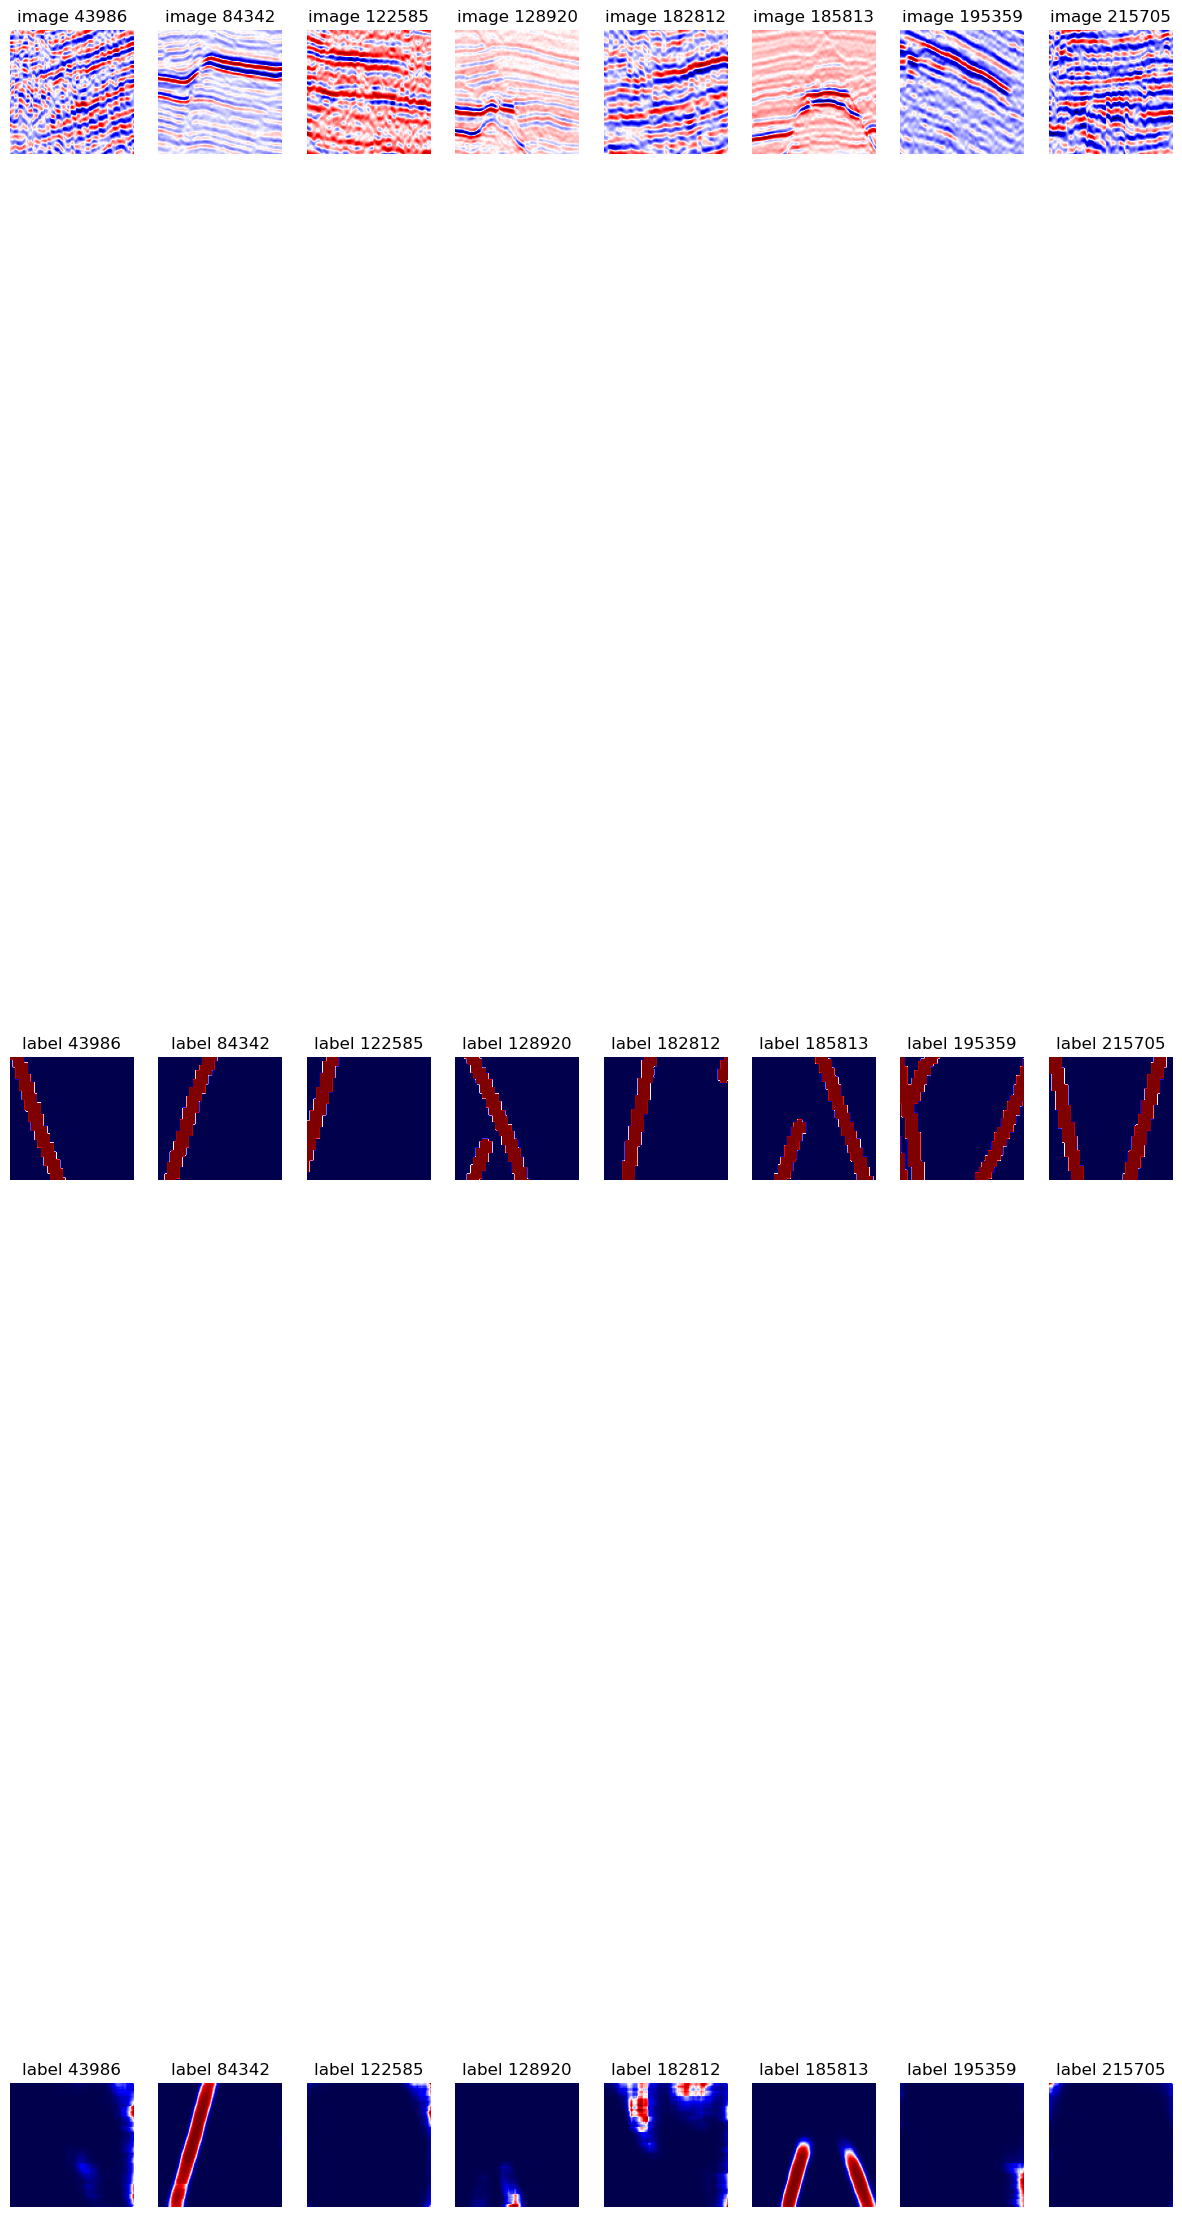

In [15]:

if INTERACTIVE_SESSION:
    seis.display_sample_images(x_test, y_test, y_pred)
    

In [16]:

scores = conf.evaluate_sklearn(y_test, y_pred,report=True)
print(scores)

evaluation elapsed time:___171.92___minutes


                      0             1  accuracy     macro avg  weighted avg
precision  9.100000e-01  7.700000e-01      0.91  8.400000e-01  9.000000e-01
recall     9.900000e-01  2.200000e-01      0.91  6.100000e-01  9.100000e-01
f1-score   9.500000e-01  3.400000e-01      0.91  6.500000e-01  8.900000e-01
support    1.841265e+09  2.242436e+08      0.91  2.065508e+09  2.065508e+09
{'Avg-precision': 0.5, 'f1-score(ODS)': 0.34}
